<a href="https://colab.research.google.com/github/antonisbast/Tools-For-Data-Science/blob/main/V3Aerial_AIDL02project_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. ***Importing all necessary libraries***

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, EfficientNetB0, MobileNetV2
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import os
import tempfile
import shutil
from google.colab import drive


***2. Importing and preparing the Datat***

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/aerial_vessel_dataset'

In [ ]:
# Verify dataset structure
print("Dataset structure:")
for class_name in ['big_ships', 'small_ships', 'no_ships']:
    class_path = os.path.join(dataset_path, class_name)
    if os.path.exists(class_path):
        num_images = len(os.listdir(class_path))
        print(f"{class_name}: {num_images} images")
    else:
        print(f"Warning: {class_name} folder not found!")

Dataset structure:
big_ships: 238 images
small_ships: 238 images
no_ships: 238 images


In [ ]:
def create_train_val_test_split(dataset_path, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
    """
    Create train/validation/test splits using train_test_split
    Returns file paths for each split
    """

    # Collect all image paths and labels
    all_image_paths = []
    all_labels = []

    class_names = ['big_ships', 'small_ships', 'no_ships']

    print("Loading image paths from folders...")

    for class_idx, class_name in enumerate(class_names):
        class_folder = os.path.join(dataset_path, class_name)

        # Get all image files in this class folder
        image_files = [f for f in os.listdir(class_folder)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

        # Create full paths
        class_image_paths = [os.path.join(class_folder, img) for img in image_files]

        # Add to our lists
        all_image_paths.extend(class_image_paths)
        all_labels.extend([class_idx] * len(class_image_paths))

        print(f"{class_name}: {len(image_files)} images")

    # Convert to numpy arrays
    all_image_paths = np.array(all_image_paths)
    all_labels = np.array(all_labels)

    print(f"\nTotal images: {len(all_image_paths)}")

    # First split: separate test set (80% temp, 20% test)
    X_temp, X_test, y_temp, y_test = train_test_split(
        all_image_paths, all_labels,
        test_size=test_ratio,
        stratify=all_labels,
        random_state=42
    )

    # Second split: from the remaining 80%, split into train and validation
    # We want 60% train and 20% val from original dataset
    # So from the 80% remaining: 60/80 = 0.75 train, 20/80 = 0.25 val
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=0.25,  # 0.25 of 0.8 = 0.2 (20% of original)
        stratify=y_temp,
        random_state=42
    )

    # Print split information
    print(f"\nDataset splits:")
    print(f"Training: {len(X_train)} images ({len(X_train)/len(all_image_paths)*100:.1f}%)")
    print(f"Validation: {len(X_val)} images ({len(X_val)/len(all_image_paths)*100:.1f}%)")
    print(f"Test: {len(X_test)} images ({len(X_test)/len(all_image_paths)*100:.1f}%)")

    # Check class distribution in each split
    print("\nClass distribution per split:")
    print(f"{'Split':<12} {'Tankers':<10} {'Bulk':<10} {'Container':<12}")
    print("-" * 50)

    for split_name, y_split in [('Train', y_train), ('Validation', y_val), ('Test', y_test)]:
        unique, counts = np.unique(y_split, return_counts=True)
        count_dict = dict(zip(unique, counts))
        tankers = count_dict.get(0, 0)
        bulk = count_dict.get(1, 0)
        container = count_dict.get(2, 0)
        print(f"{split_name:<12} {tankers:<10} {bulk:<10} {container:<12}")

    return (X_train, y_train), (X_val, y_val), (X_test, y_test), class_names

In [ ]:
def create_temp_directories_for_generators(X_train, y_train, X_val, y_val, X_test, y_test, class_names):
    """
    Create temporary directories for ImageDataGenerator
    This creates symbolic links instead of copying files (much faster)
    """

    temp_dir = '/tmp/vessel_splits'

    # Remove if exists
    if os.path.exists(temp_dir):
        shutil.rmtree(temp_dir)

    # Create directory structure
    for split in ['train', 'val', 'test']:
        for class_name in class_names:
            os.makedirs(os.path.join(temp_dir, split, class_name), exist_ok=True)

    # Create symbolic links (much faster than copying)
    datasets = [
        ('train', X_train, y_train),
        ('val', X_val, y_val),
        ('test', X_test, y_test)
    ]

    for split_name, X_split, y_split in datasets:
        for img_path, label in zip(X_split, y_split):
            class_name = class_names[label]

            # Create symbolic link
            img_filename = os.path.basename(img_path)
            link_path = os.path.join(temp_dir, split_name, class_name, img_filename)

            try:
                os.symlink(img_path, link_path)
            except:
                # If symlink fails (some systems), copy the file
                shutil.copy2(img_path, link_path)

    return os.path.join(temp_dir, 'train'), os.path.join(temp_dir, 'val'), os.path.join(temp_dir, 'test')

In [ ]:
def create_basic_generators(train_dir, val_dir, test_dir, img_size=(128, 128), batch_size=16):
    """Create basic data generators without augmentation"""

    datagen = ImageDataGenerator(rescale=1./255)

    train_generator = datagen.flow_from_directory(
        train_dir, target_size=img_size, batch_size=batch_size,
        class_mode='categorical', shuffle=True)

    validation_generator = datagen.flow_from_directory(
        val_dir, target_size=img_size, batch_size=batch_size,
        class_mode='categorical', shuffle=False)

    test_generator = datagen.flow_from_directory(
        test_dir, target_size=img_size, batch_size=batch_size,
        class_mode='categorical', shuffle=False)

    return train_generator, validation_generator, test_generator

In [ ]:
def create_augmented_generators(train_dir, val_dir, test_dir, img_size=(128, 128), batch_size=16):
    """Create data generators with augmentation for training"""

    # Strong augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.05,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='reflect',
        brightness_range=[0.9, 1.1],
        channel_shift_range=0.1,
    )

    # Only rescaling for validation and test
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir, target_size=img_size, batch_size=batch_size,
        class_mode='categorical', shuffle=True)

    validation_generator = val_test_datagen.flow_from_directory(
        val_dir, target_size=img_size, batch_size=batch_size,
        class_mode='categorical', shuffle=False)

    test_generator = val_test_datagen.flow_from_directory(
        test_dir, target_size=img_size, batch_size=batch_size,
        class_mode='categorical', shuffle=False)

    return train_generator, validation_generator, test_generator

3. ***Training and evaluation functions***

In [ ]:
def train_model(model, train_gen, val_gen, model_name, epochs=20):
    """Train a model with callbacks"""

    callbacks = [
        ModelCheckpoint(f'best_{model_name}.h5', monitor='val_accuracy',
                       save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5,
                         min_lr=1e-7, verbose=1)
        ]

    import math
    steps_per_epoch = math.ceil(train_gen.samples / train_gen.batch_size)
    validation_steps = math.ceil(val_gen.samples / val_gen.batch_size)

    print(f"\n{'='*50}")
    print(f"TRAINING {model_name.upper()}")
    print(f"{'='*50}")

    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_gen,
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=1
    )

    return history

In [ ]:
def plot_training_history(history, model_name):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    ax1.set_title(f'{model_name} - Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Loss plot
    ax2.plot(history.history['loss'], 'b-', label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax2.set_title(f'{model_name} - Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print final results
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    best_val_acc = max(history.history['val_accuracy'])

    print(f"\n📊 {model_name} RESULTS:")
    print(f"Final Training Accuracy: {final_train_acc:.4f}")
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")

    return best_val_acc

In [ ]:
def evaluate_model(model, test_gen, model_name, class_names):
    """Comprehensive model evaluation"""

    print(f"\n{'='*50}")
    print(f"EVALUATING {model_name.upper()} ON TEST SET")
    print(f"{'='*50}")

    # Evaluate on test set
    import math
    test_steps = math.ceil(test_gen.samples / test_gen.batch_size)
    test_loss, test_accuracy = model.evaluate(test_gen, steps=test_steps, verbose=1)

    print(f"\n🎯 TEST RESULTS:")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Generate predictions for confusion matrix
    test_gen.reset()
    predictions = model.predict(test_gen, steps=test_steps, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_gen.classes[:len(predicted_classes)]

    # Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Classification Report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=class_names))

    return test_accuracy, test_loss

4. ***Preparing data***

In [ ]:
# Set parameters
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 16
NUM_CLASSES = 3

# Create train/val/test splits
(X_train, y_train), (X_val, y_val), (X_test, y_test), class_names = create_train_val_test_split(dataset_path)

# Create temporary directories
train_dir, val_dir, test_dir = create_temp_directories_for_generators(
    X_train, y_train, X_val, y_val, X_test, y_test, class_names)

# Create basic generators (no augmentation for Part 1)
train_gen_basic, val_gen_basic, test_gen_basic = create_basic_generators(
    train_dir, val_dir, test_dir, (IMG_HEIGHT, IMG_WIDTH), BATCH_SIZE)

print("Data preparation completed!")
print(f"Class names: {class_names}")


Loading image paths from folders...
big_ships: 238 images
small_ships: 237 images
no_ships: 231 images

Total images: 706

Dataset splits:
Training: 423 images (59.9%)
Validation: 141 images (20.0%)
Test: 142 images (20.1%)

Class distribution per split:
Split        Tankers    Bulk       Container   
--------------------------------------------------
Train        142        142        139         
Validation   48         47         46          
Test         48         48         46          
Found 423 images belonging to 3 classes.
Found 141 images belonging to 3 classes.
Found 142 images belonging to 3 classes.
Data preparation completed!
Class names: ['big_ships', 'small_ships', 'no_ships']


***5. Custom CNNs creation***

In [ ]:
def create_cnn_architecture_1():
    """Simple CNN - Light architecture for quick training"""
    model = Sequential()
    model.add(Conv2D(32, (3, 3),padding='same', activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPool2D((2, 2)))
    model.add(Conv2D(64, (3, 3),padding='same', activation='relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(Conv2D(128, (3, 3),padding='same', activation='relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
def create_cnn_architecture_2():
    """Deeper CNN with BatchNormalization and more regularization"""
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPool2D((2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.20))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001),  # Fine-tuned LR
                 loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
def create_cnn_architecture_3():
    """Moderate CNN - Between simple and complex"""
    model = Sequential()
    model.add(Conv2D(64, (3, 3),padding='same', activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPool2D((2, 2)))

    model.add(Conv2D(128, (3, 3),padding='same', activation='relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(256, (3, 3),padding='same', activation='relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(512, (3, 3),padding='same', activation='relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.30))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='categorical_crossentropy', metrics=['accuracy'])

    print("\n🏗️ CNN Architecture 3: Moderate Complexity")
    print("- 4 Conv2D layers (32, 64, 128, 128)")
    print("- Larger dense layer (256 units)")
    print("- Learning rate: 0.001")
    print("- Focus: Balanced complexity")

    return model


In [ ]:
def create_cnn_architecture_4():
    """Alternative CNN - Different design choices"""
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPool2D((2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001),  # Fine-tuned LR
                 loss='categorical_crossentropy', metrics=['accuracy'])

    print("\n🏗️ CNN Architecture 4: Alternative Design")
    print("- 3 Conv2D layers with larger initial filter (5x5)")
    print("- GlobalAveragePooling instead of Flatten")
    print("- Learning rate: 0.0008")
    print("- Focus: Different architectural choices")

    return model

In [ ]:
# Storage for Part 1 results
part1_results = {}

***6. Training, evaluation and comparison of CNNs.***


🔥 EXPERIMENT 1: Training Simple CNN


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,067 (16.36 MB)

 Trainable params: 4,288,067 (16.36 MB)

 Non-trainable params: 0 (0.00 B)


TRAINING CNN_ARCH_1


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4623 - loss: 1.1011
Epoch 1: val_accuracy improved from -inf to 0.70922, saving model to best_cnn_arch_1.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 134s 5s/step - accuracy: 0.4638 - loss: 1.0981 - val_accuracy: 0.7092 - val_loss: 0.7525 - learning_rate: 0.0010
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.6603 - loss: 0.7994
Epoch 2: val_accuracy improved from 0.70922 to 0.74468, saving model to best_cnn_arch_1.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 480ms/step - accuracy: 0.6601 - loss: 0.8002 - val_accuracy: 0.7447 - val_loss: 0.7223 - learning_rate: 0.0010
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.7147 - loss: 0.7114
Epoch 3: val_accuracy did not improve from 0.74468
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 454ms/step - accuracy: 0.7139 - loss: 0.7128 - val_accuracy: 0.7234 - val_loss: 0.7218 - learning_rate: 0.0010
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.7155 - loss: 0.7118
Epoch 4: val_accuracy did not improve from 0.74468
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 462ms/step - accuracy: 0.7155 - loss: 0.7108 - val_accuracy: 0.7305 - val_loss: 0.6282 - learning_rate: 0.0010
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.7523 - loss: 0.6205
Epoch 5: val_accuracy improved from 0.74468 to 0.75177, saving model to best_cnn_arch_1.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 499ms/step - accuracy: 0.7535 - loss: 0.6185 - val_accuracy: 0.7518 - val_loss: 0.6611 - learning_rate: 0.0010
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.8378 - loss: 0.4374
Epoch 6: val_accuracy did not improve from 0.75177
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 557ms/step - accuracy: 0.8372 - loss: 0.4373 - val_accuracy: 0.7518 - val_loss: 0.5907 - learning_rate: 0.0010
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.8481 - loss: 0.3863
Epoch 7: val_accuracy improved from 0.75177 to 0.78723, saving model to best_cnn_arch_1.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 455ms/step - accuracy: 0.8481 - loss: 0.3857 - val_accuracy: 0.7872 - val_loss: 0.5580 - learning_rate: 0.0010
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.8993 - loss: 0.2400
Epoch 8: val_accuracy improved from 0.78723 to 0.82270, saving model to best_cnn_arch_1.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 480ms/step - accuracy: 0.8989 - loss: 0.2415 - val_accuracy: 0.8227 - val_loss: 0.5157 - learning_rate: 0.0010
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9113 - loss: 0.2545
Epoch 9: val_accuracy did not improve from 0.82270
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 485ms/step - accuracy: 0.9111 - loss: 0.2552 - val_accuracy: 0.7943 - val_loss: 0.5509 - learning_rate: 0.0010
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9340 - loss: 0.1941
Epoch 10: val_accuracy did not improve from 0.82270
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 489ms/step - accuracy: 0.9346 - loss: 0.1931 - val_accuracy: 0.8085 - val_loss: 0.6038 - learning_rate: 0.0010
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9224 - loss: 0.1695
Epoch 11: val_accuracy did not improve from 0.82270
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 471ms/step - accuracy: 0.9229 - loss: 0.1695 - val_accuracy: 0.7872 - val_loss: 0.6338 - learning_rate: 0.0010
Epoch 12/20
27/27

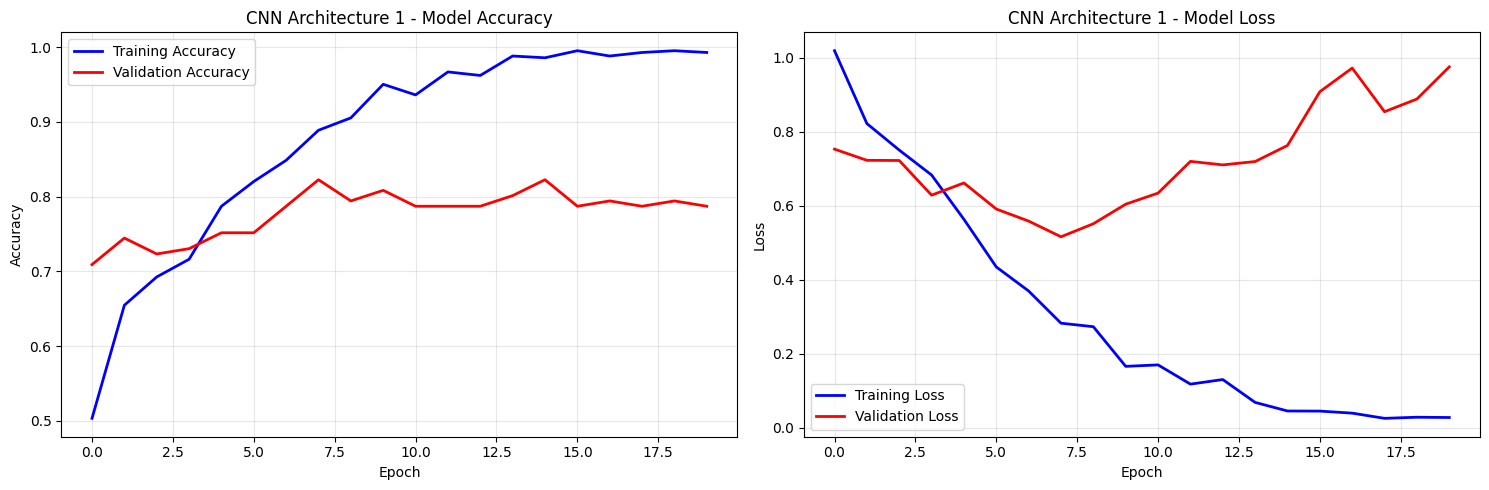


📊 CNN Architecture 1 RESULTS:
Final Training Accuracy: 0.9929
Final Validation Accuracy: 0.7872
Best Validation Accuracy: 0.8227

EVALUATING CNN ARCHITECTURE 1 ON TEST SET
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.7414 - loss: 0.8312

🎯 TEST RESULTS:
Test Accuracy: 0.7606
Test Loss: 0.7798
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 339ms/step


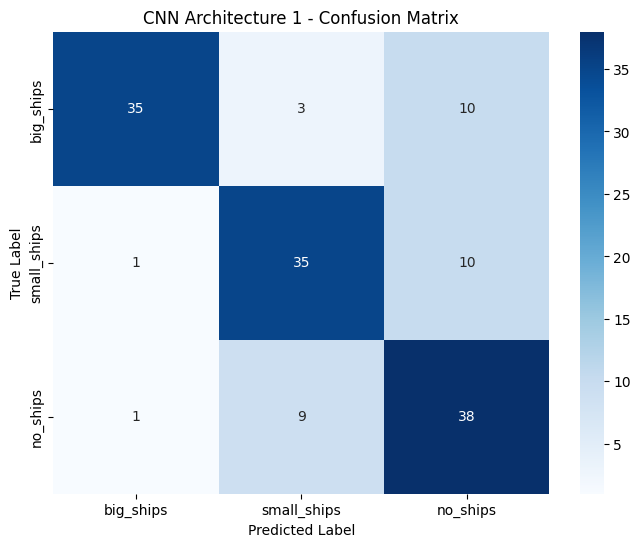


CNN Architecture 1 Classification Report:
              precision    recall  f1-score   support

   big_ships       0.95      0.73      0.82        48
 small_ships       0.74      0.76      0.75        46
    no_ships       0.66      0.79      0.72        48

    accuracy                           0.76       142
   macro avg       0.78      0.76      0.76       142
weighted avg       0.78      0.76      0.76       142



In [ ]:
# Architecture 1
print("\n🔥 EXPERIMENT 1: Training Simple CNN")
model_1 = create_cnn_architecture_1()
model_1.summary()
history_1 = train_model(model_1, train_gen_basic, val_gen_basic, "cnn_arch_1", epochs=20)
val_acc_1 = plot_training_history(history_1, "CNN Architecture 1")
test_acc_1, _ = evaluate_model(model_1, test_gen_basic, "CNN Architecture 1", class_names)
part1_results['CNN Architecture 1'] = {'val_acc': val_acc_1, 'test_acc': test_acc_1, 'model': model_1}


🔥 EXPERIMENT 2: Training Deeper CNN with Regularization


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,149,059 (65.42 MB)

 Trainable params: 17,149,059 (65.42 MB)

 Non-trainable params: 0 (0.00 B)


TRAINING CNN_ARCH_2
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.3372 - loss: 1.4768
Epoch 1: val_accuracy improved from -inf to 0.63121, saving model to best_cnn_arch_2.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 740ms/step - accuracy: 0.3396 - loss: 1.4666 - val_accuracy: 0.6312 - val_loss: 0.8356 - learning_rate: 0.0010
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.5790 - loss: 0.9458
Epoch 2: val_accuracy improved from 0.63121 to 0.66667, saving model to best_cnn_arch_2.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 525ms/step - accuracy: 0.5793 - loss: 0.9465 - val_accuracy: 0.6667 - val_loss: 0.7702 - learning_rate: 0.0010
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.6301 - loss: 0.8476
Epoch 3: val_accuracy did not improve from 0.66667
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 500ms/step - accuracy: 0.6311 - loss: 0.8462 - val_accuracy: 0.5603 - val_loss: 0.9315 - learning_rate: 0.0010
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.6724 - loss: 0.7473
Epoch 4: val_accuracy improved from 0.66667 to 0.75177, saving model to best_cnn_arch_2.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 521ms/step - accuracy: 0.6729 - loss: 0.7474 - val_accuracy: 0.7518 - val_loss: 0.6581 - learning_rate: 0.0010
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.7010 - loss: 0.6446
Epoch 5: val_accuracy did not improve from 0.75177
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 496ms/step - accuracy: 0.7013 - loss: 0.6438 - val_accuracy: 0.7518 - val_loss: 0.6214 - learning_rate: 0.0010
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.7350 - loss: 0.5780
Epoch 6: val_accuracy improved from 0.75177 to 0.76596, saving model to best_cnn_arch_2.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 522ms/step - accuracy: 0.7351 - loss: 0.5781 - val_accuracy: 0.7660 - val_loss: 0.5302 - learning_rate: 0.0010
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8013 - loss: 0.4911
Epoch 7: val_accuracy improved from 0.76596 to 0.81560, saving model to best_cnn_arch_2.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 520ms/step - accuracy: 0.8011 - loss: 0.4906 - val_accuracy: 0.8156 - val_loss: 0.5484 - learning_rate: 0.0010
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.8912 - loss: 0.3967
Epoch 8: val_accuracy did not improve from 0.81560
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 496ms/step - accuracy: 0.8908 - loss: 0.3964 - val_accuracy: 0.7943 - val_loss: 0.5199 - learning_rate: 0.0010
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.8538 - loss: 0.3765
Epoch 9: val_accuracy did not improve from 0.81560
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 506ms/step - accuracy: 0.8546 - loss: 0.3753 - val_accuracy: 0.8085 - val_loss: 0.5373 - learning_rate: 0.0010
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.9444 - loss: 0.2223
Epoch 10: val_accuracy did not improve from 0.81560
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 482ms/step - accuracy: 0.9435 - loss: 0.2232 - val_accuracy: 0.7801 - val_loss: 0.6821 - learning_rate: 0.0010
Epoch 11/20
27/27 ━

27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 535ms/step - accuracy: 0.9572 - loss: 0.1601 - val_accuracy: 0.8227 - val_loss: 0.6220 - learning_rate: 0.0010
Epoch 13/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9429 - loss: 0.1468
Epoch 13: val_accuracy did not improve from 0.82270

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 498ms/step - accuracy: 0.9427 - loss: 0.1469 - val_accuracy: 0.8014 - val_loss: 0.7141 - learning_rate: 0.0010
Epoch 14/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.9818 - loss: 0.0608
Epoch 14: val_accuracy did not improve from 0.82270
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 502ms/step - accuracy: 0.9820 - loss: 0.0606 - val_accuracy: 0.7943 - val_loss: 0.6793 - learning_rate: 3.0000e-04
Epoch 15/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9726 - loss: 0.0780
Epoch 15: val_accuracy improved from 0.82270 to 0.82979, saving model to best_cnn_arch_2.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 494ms/step - accuracy: 0.9727 - loss: 0.0775 - val_accuracy: 0.8298 - val_loss: 0.6598 - learning_rate: 3.0000e-04
Epoch 16/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9920 - loss: 0.0434
Epoch 16: val_accuracy did not improve from 0.82979
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 482ms/step - accuracy: 0.9919 - loss: 0.0433 - val_accuracy: 0.7660 - val_loss: 0.8366 - learning_rate: 3.0000e-04
Epoch 17/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9900 - loss: 0.0375
Epoch 17: val_accuracy did not improve from 0.82979
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 501ms/step - accuracy: 0.9897 - loss: 0.0377 - val_accuracy: 0.8227 - val_loss: 0.7099 - learning_rate: 3.0000e-04
Epoch 18/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.9933 - loss: 0.0286
Epoch 18: val_accuracy did not improve from 0.82979

Epoch 18: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 503ms/step - accuracy: 0.9931 - loss

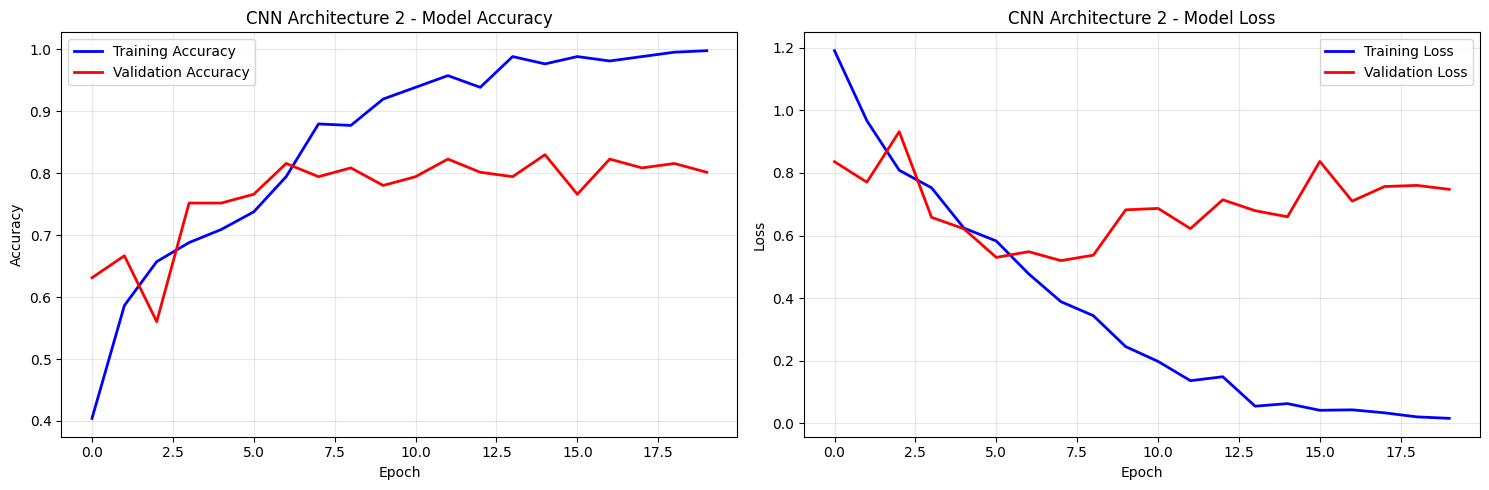


📊 CNN Architecture 2 RESULTS:
Final Training Accuracy: 0.9976
Final Validation Accuracy: 0.8014
Best Validation Accuracy: 0.8298

EVALUATING CNN ARCHITECTURE 2 ON TEST SET
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 463ms/step - accuracy: 0.7840 - loss: 0.7104

🎯 TEST RESULTS:
Test Accuracy: 0.8239
Test Loss: 0.6860
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step


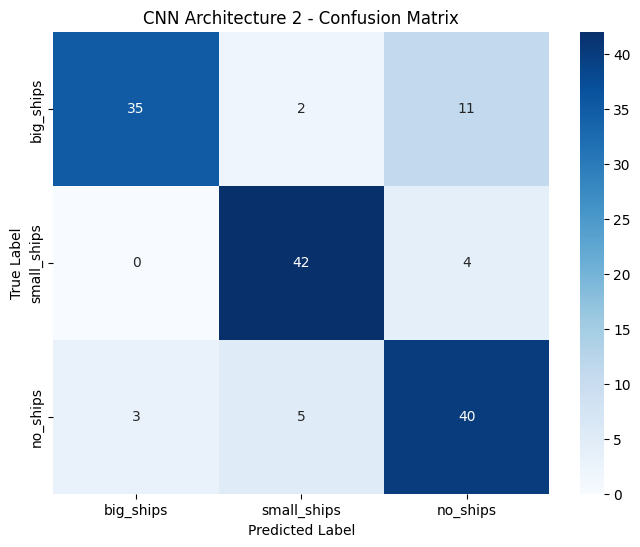


CNN Architecture 2 Classification Report:
              precision    recall  f1-score   support

   big_ships       0.92      0.73      0.81        48
 small_ships       0.86      0.91      0.88        46
    no_ships       0.73      0.83      0.78        48

    accuracy                           0.82       142
   macro avg       0.84      0.83      0.82       142
weighted avg       0.83      0.82      0.82       142



In [ ]:
# Architecture 2
print("\n🔥 EXPERIMENT 2: Training Deeper CNN with Regularization")
model_2 = create_cnn_architecture_2()
model_2.summary()
history_2 = train_model(model_2, train_gen_basic, val_gen_basic, "cnn_arch_2", epochs=20)
val_acc_2 = plot_training_history(history_2, "CNN Architecture 2")
test_acc_2, _ = evaluate_model(model_2, test_gen_basic, "CNN Architecture 2", class_names)
part1_results['CNN Architecture 2'] = {'val_acc': val_acc_2, 'test_acc': test_acc_2, 'model': model_2}


🔥 EXPERIMENT 3: Training Complex Multi-Scale CNN

🏗️ CNN Architecture 3: Moderate Complexity
- 4 Conv2D layers (32, 64, 128, 128)
- Larger dense layer (256 units)
- Learning rate: 0.001
- Focus: Balanced complexity


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,942,147 (37.93 MB)

 Trainable params: 9,941,379 (37.92 MB)

 Non-trainable params: 768 (3.00 KB)


TRAINING CNN_ARCH_3
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.3543 - loss: 15.5796
Epoch 1: val_accuracy improved from -inf to 0.41135, saving model to best_cnn_arch_3.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 701ms/step - accuracy: 0.3552 - loss: 15.4143 - val_accuracy: 0.4113 - val_loss: 1.0951 - learning_rate: 0.0010
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.4976 - loss: 1.2316
Epoch 2: val_accuracy did not improve from 0.41135
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 488ms/step - accuracy: 0.4964 - loss: 1.2291 - val_accuracy: 0.3262 - val_loss: 1.0925 - learning_rate: 0.0010
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.4509 - loss: 1.0089
Epoch 3: val_accuracy did not improve from 0.41135
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 490ms/step - accuracy: 0.4503 - loss: 1.0102 - val_accuracy: 0.3262 - val_loss: 1.0962 - learning_rate: 0.0010
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.3043 - loss: 1.1265
Epoch 4: val_accuracy did not improve from 0.41135
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 475ms/step - accuracy: 0.3057 - loss: 1.1249 - val_accuracy: 0.3333 - val_loss: 1.0987 - learning_rate: 0.0010
Epoch 5/20
27/27 ━━━

27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 516ms/step - accuracy: 0.4790 - loss: 0.9848 - val_accuracy: 0.4468 - val_loss: 1.0604 - learning_rate: 0.0010
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.4804 - loss: 0.9921
Epoch 10: val_accuracy improved from 0.44681 to 0.47518, saving model to best_cnn_arch_3.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 502ms/step - accuracy: 0.4797 - loss: 0.9929 - val_accuracy: 0.4752 - val_loss: 0.9971 - learning_rate: 0.0010
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.4658 - loss: 1.1152
Epoch 11: val_accuracy improved from 0.47518 to 0.48936, saving model to best_cnn_arch_3.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 509ms/step - accuracy: 0.4648 - loss: 1.1148 - val_accuracy: 0.4894 - val_loss: 1.0592 - learning_rate: 0.0010
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.4401 - loss: 1.0080
Epoch 12: val_accuracy improved from 0.48936 to 0.51064, saving model to best_cnn_arch_3.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 510ms/step - accuracy: 0.4404 - loss: 1.0080 - val_accuracy: 0.5106 - val_loss: 1.0251 - learning_rate: 0.0010
Epoch 13/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.4372 - loss: 1.0216
Epoch 13: val_accuracy did not improve from 0.51064
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 507ms/step - accuracy: 0.4378 - loss: 1.0210 - val_accuracy: 0.4539 - val_loss: 1.0337 - learning_rate: 0.0010
Epoch 14/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.4701 - loss: 0.9566
Epoch 14: val_accuracy did not improve from 0.51064
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 587ms/step - accuracy: 0.4699 - loss: 0.9575 - val_accuracy: 0.4965 - val_loss: 1.0021 - learning_rate: 0.0010
Epoch 15/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.5220 - loss: 0.9710
Epoch 15: val_accuracy did not improve from 0.51064

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 493ms/step - accuracy: 0.5209 - loss: 0.9712 - v

27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 506ms/step - accuracy: 0.4912 - loss: 0.9905 - val_accuracy: 0.5248 - val_loss: 0.9563 - learning_rate: 3.0000e-04
Epoch 18/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.4693 - loss: 0.9477
Epoch 18: val_accuracy did not improve from 0.52482
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 496ms/step - accuracy: 0.4699 - loss: 0.9479 - val_accuracy: 0.4894 - val_loss: 0.9602 - learning_rate: 3.0000e-04
Epoch 19/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.4891 - loss: 0.9409
Epoch 19: val_accuracy did not improve from 0.52482
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 504ms/step - accuracy: 0.4897 - loss: 0.9403 - val_accuracy: 0.5248 - val_loss: 0.9091 - learning_rate: 3.0000e-04
Epoch 20/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.4613 - loss: 0.9303
Epoch 20: val_accuracy improved from 0.52482 to 0.56028, saving model to best_cnn_arch_3.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 502ms/step - accuracy: 0.4624 - loss: 0.9297 - val_accuracy: 0.5603 - val_loss: 0.9062 - learning_rate: 3.0000e-04


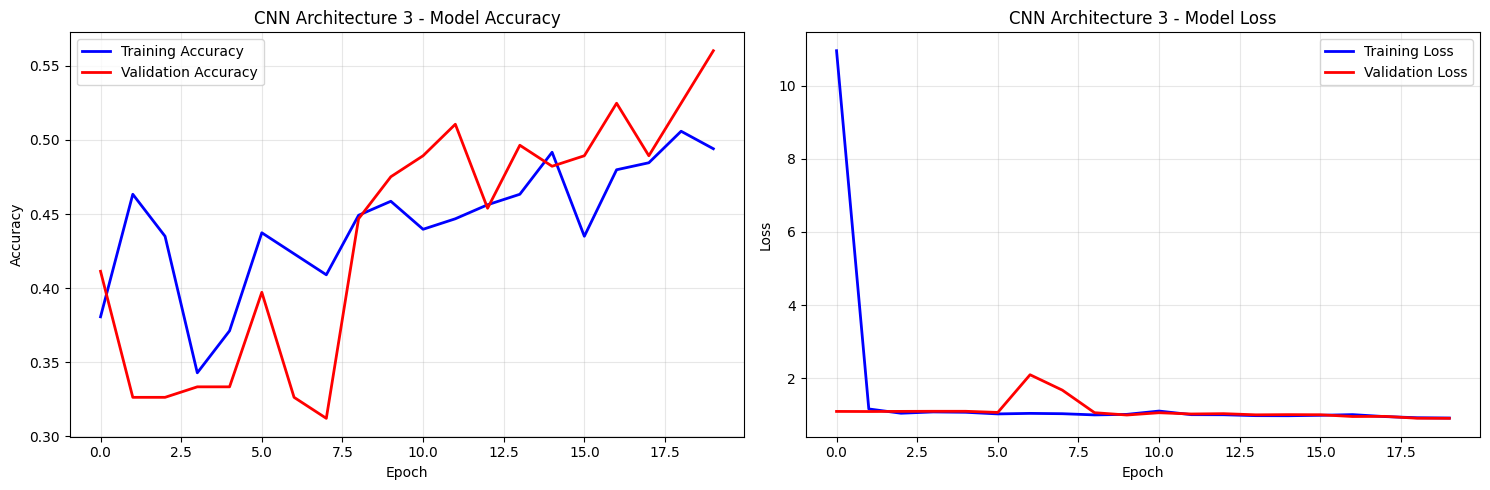


📊 CNN Architecture 3 RESULTS:
Final Training Accuracy: 0.4941
Final Validation Accuracy: 0.5603
Best Validation Accuracy: 0.5603

EVALUATING CNN ARCHITECTURE 3 ON TEST SET
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 419ms/step - accuracy: 0.6191 - loss: 0.8222

🎯 TEST RESULTS:
Test Accuracy: 0.5845
Test Loss: 0.9324
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 359ms/step


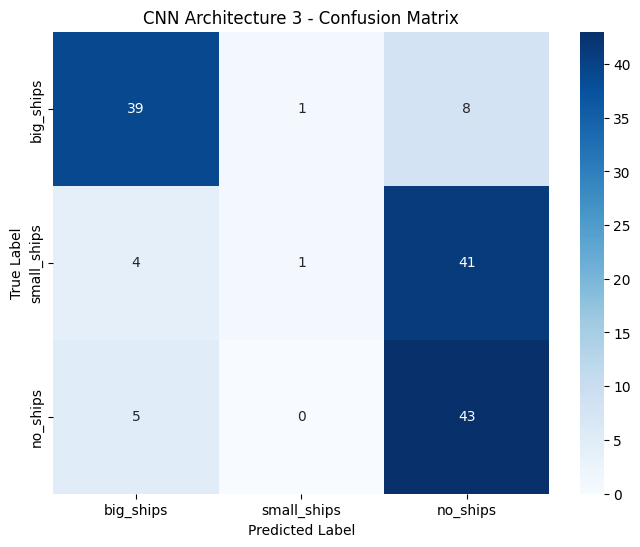


CNN Architecture 3 Classification Report:
              precision    recall  f1-score   support

   big_ships       0.81      0.81      0.81        48
 small_ships       0.50      0.02      0.04        46
    no_ships       0.47      0.90      0.61        48

    accuracy                           0.58       142
   macro avg       0.59      0.58      0.49       142
weighted avg       0.59      0.58      0.50       142



In [ ]:
# Architecture 3
print("\n🔥 EXPERIMENT 3: Training Complex Multi-Scale CNN")
model_3 = create_cnn_architecture_3()
model_3.summary()
history_3 = train_model(model_3, train_gen_basic, val_gen_basic, "cnn_arch_3", epochs=20)
val_acc_3 = plot_training_history(history_3, "CNN Architecture 3")
test_acc_3, _ = evaluate_model(model_3, test_gen_basic, "CNN Architecture 3", class_names)
part1_results['CNN Architecture 3'] = {'val_acc': val_acc_3, 'test_acc': test_acc_3, 'model': model_3}



🔥 EXPERIMENT 4: Training Wide & Shallow CNN

🏗️ CNN Architecture 4: Alternative Design

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



- 3 Conv2D layers with larger initial filter (5x5)
- GlobalAveragePooling instead of Flatten
- Learning rate: 0.0008
- Focus: Different architectural choices


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,333,827 (69.94 MB)

 Trainable params: 18,332,035 (69.93 MB)

 Non-trainable params: 1,792 (7.00 KB)


TRAINING CNN_ARCH_4
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.4659 - loss: 14.1553
Epoch 1: val_accuracy improved from -inf to 0.43262, saving model to best_cnn_arch_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 686ms/step - accuracy: 0.4676 - loss: 14.1796 - val_accuracy: 0.4326 - val_loss: 10.7217 - learning_rate: 0.0010
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.6308 - loss: 14.0113
Epoch 2: val_accuracy improved from 0.43262 to 0.54610, saving model to best_cnn_arch_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 515ms/step - accuracy: 0.6316 - loss: 13.9451 - val_accuracy: 0.5461 - val_loss: 7.1653 - learning_rate: 0.0010
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.6847 - loss: 9.2108
Epoch 3: val_accuracy did not improve from 0.54610
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 497ms/step - accuracy: 0.6851 - loss: 9.2078 - val_accuracy: 0.3759 - val_loss: 9.6106 - learning_rate: 0.0010
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.6791 - loss: 6.6125
Epoch 4: val_accuracy did not improve from 0.54610
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 478ms/step - accuracy: 0.6785 - loss: 6.6623 - val_accuracy: 0.5177 - val_loss: 4.0359 - learning_rate: 0.0010
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.7161 - loss: 7.3658
Epoch 5: val_accuracy did not improve from 0.54610
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 547ms/step - accuracy: 0.7166 - loss: 7.3671 - val_accuracy: 0.5106 - val_loss: 4.4219 - learning_rate: 0.0010
Epoch 6/20
27/27 ━━━

27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 515ms/step - accuracy: 0.8096 - loss: 3.5010 - val_accuracy: 0.6596 - val_loss: 7.7700 - learning_rate: 3.0000e-04
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8832 - loss: 1.1168
Epoch 11: val_accuracy did not improve from 0.65957
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 492ms/step - accuracy: 0.8834 - loss: 1.1201 - val_accuracy: 0.5887 - val_loss: 6.2143 - learning_rate: 3.0000e-04
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.9003 - loss: 1.5353
Epoch 12: val_accuracy did not improve from 0.65957
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 500ms/step - accuracy: 0.8998 - loss: 1.5441 - val_accuracy: 0.6099 - val_loss: 5.4995 - learning_rate: 3.0000e-04
Epoch 13/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.8876 - loss: 1.1697
Epoch 13: val_accuracy did not improve from 0.65957
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 498ms/step - accuracy: 0.8882 - loss: 1.1753 - val_accuracy: 0.5887 - val_loss: 6.0615 - learning_rate: 3.0000e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 520ms/step - accuracy: 0.9187 - loss: 0.6262 - val_accuracy: 0.7234 - val_loss: 3.7473 - learning_rate: 3.0000e-04
Epoch 15/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.9322 - loss: 0.5591
Epoch 15: val_accuracy did not improve from 0.72340
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 555ms/step - accuracy: 0.9322 - loss: 0.5589 - val_accuracy: 0.7021 - val_loss: 4.0420 - learning_rate: 3.0000e-04
Epoch 16/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9357 - loss: 0.6291
Epoch 16: val_accuracy did not improve from 0.72340
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 502ms/step - accuracy: 0.9357 - loss: 0.6258 - val_accuracy: 0.7163 - val_loss: 3.3832 - learning_rate: 3.0000e-04
Epoch 17/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.9463 - loss: 0.3754
Epoch 17: val_accuracy improved from 0.72340 to 0.77305, saving model to best_cnn_arch_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 522ms/step - accuracy: 0.9468 - loss: 0.3711 - val_accuracy: 0.7730 - val_loss: 3.1520 - learning_rate: 3.0000e-04
Epoch 18/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9467 - loss: 0.2317
Epoch 18: val_accuracy improved from 0.77305 to 0.78014, saving model to best_cnn_arch_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 525ms/step - accuracy: 0.9468 - loss: 0.2326 - val_accuracy: 0.7801 - val_loss: 3.5144 - learning_rate: 3.0000e-04
Epoch 19/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9807 - loss: 0.0955
Epoch 19: val_accuracy improved from 0.78014 to 0.78723, saving model to best_cnn_arch_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 548ms/step - accuracy: 0.9801 - loss: 0.0981 - val_accuracy: 0.7872 - val_loss: 3.4274 - learning_rate: 3.0000e-04
Epoch 20/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9542 - loss: 0.3420
Epoch 20: val_accuracy improved from 0.78723 to 0.80851, saving model to best_cnn_arch_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 512ms/step - accuracy: 0.9539 - loss: 0.3413 - val_accuracy: 0.8085 - val_loss: 3.0885 - learning_rate: 3.0000e-04


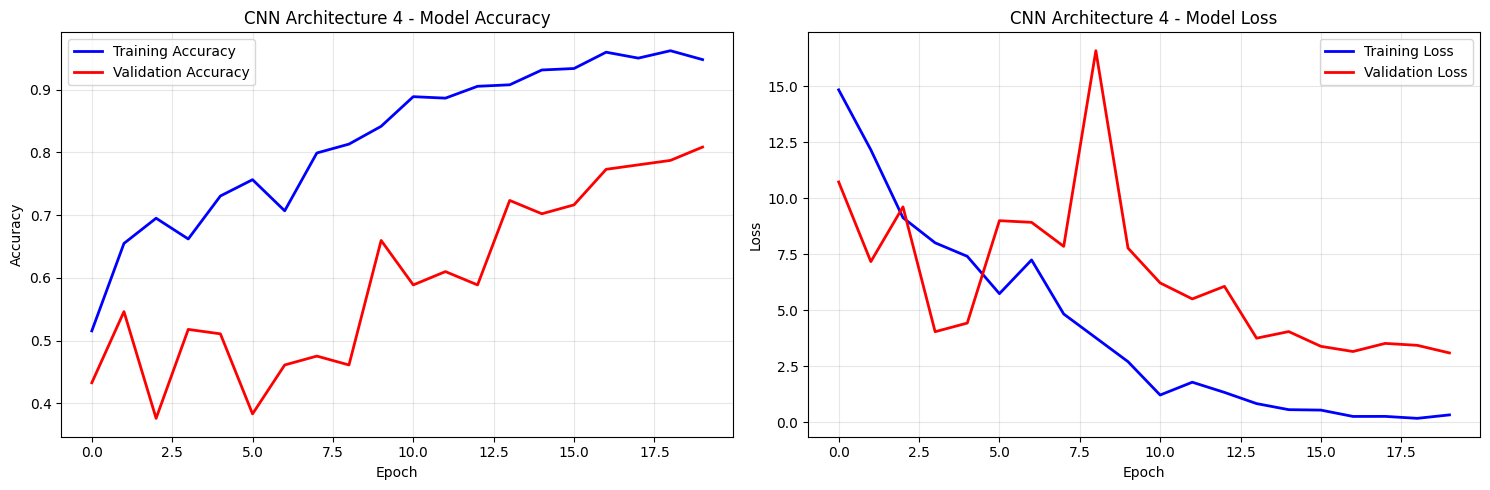


📊 CNN Architecture 4 RESULTS:
Final Training Accuracy: 0.9480
Final Validation Accuracy: 0.8085
Best Validation Accuracy: 0.8085

EVALUATING CNN ARCHITECTURE 4 ON TEST SET
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 428ms/step - accuracy: 0.6994 - loss: 3.4662

🎯 TEST RESULTS:
Test Accuracy: 0.7183
Test Loss: 3.4089
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 359ms/step


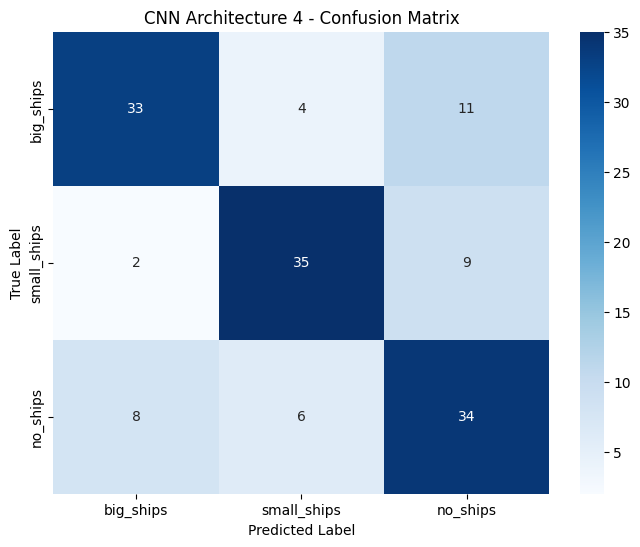


CNN Architecture 4 Classification Report:
              precision    recall  f1-score   support

   big_ships       0.77      0.69      0.73        48
 small_ships       0.78      0.76      0.77        46
    no_ships       0.63      0.71      0.67        48

    accuracy                           0.72       142
   macro avg       0.72      0.72      0.72       142
weighted avg       0.72      0.72      0.72       142



In [ ]:
# Architecture 4
print("\n🔥 EXPERIMENT 4: Training Wide & Shallow CNN")
model_4 = create_cnn_architecture_4()
model_4.summary()
history_4 = train_model(model_4, train_gen_basic, val_gen_basic, "cnn_arch_4", epochs=20)
val_acc_4 = plot_training_history(history_4, "CNN Architecture 4")
test_acc_4, _ = evaluate_model(model_4, test_gen_basic, "CNN Architecture 4", class_names)
part1_results['CNN Architecture 4'] = {'val_acc': val_acc_4, 'test_acc': test_acc_4, 'model': model_4}


📊 PART 1 RESULTS COMPARISON


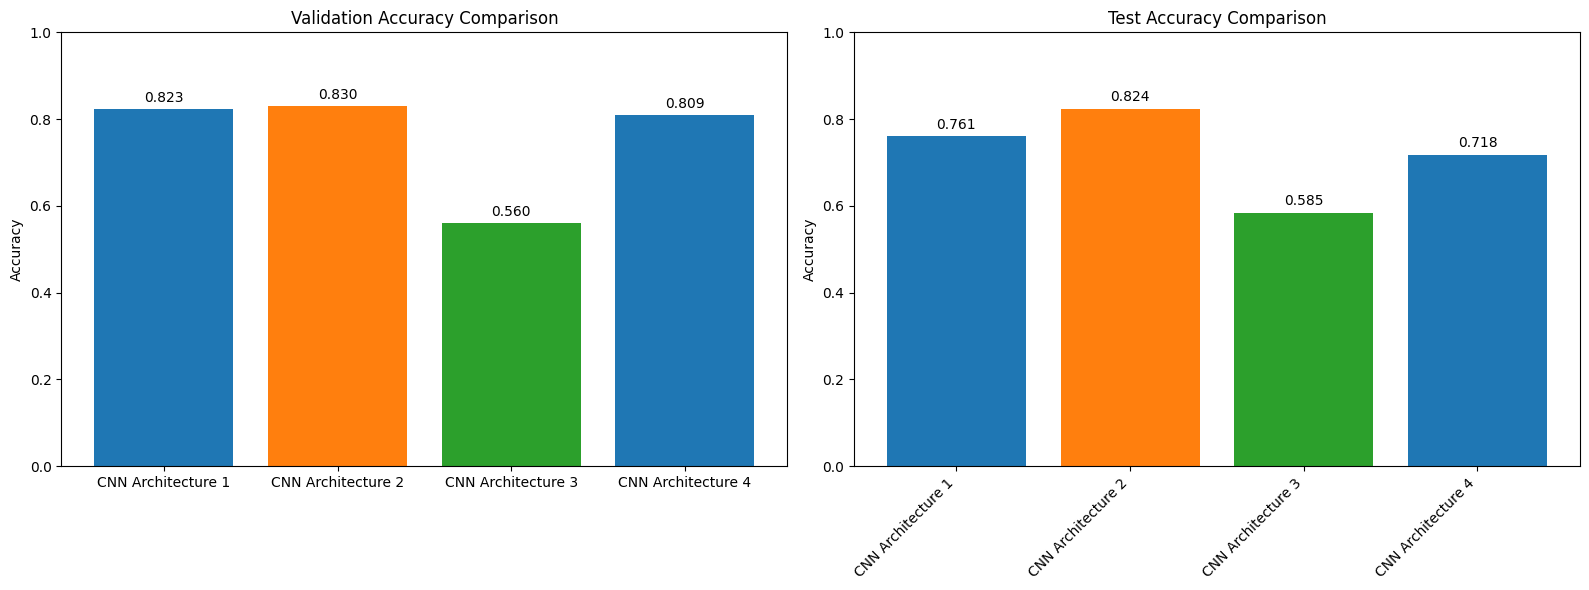


🏆 PART 1 CONCLUSION:
----------------------------------------
CNN Architecture 1:
  Validation Accuracy: 0.8227
  Test Accuracy: 0.7606

CNN Architecture 2:
  Validation Accuracy: 0.8298
  Test Accuracy: 0.8239

CNN Architecture 3:
  Validation Accuracy: 0.5603
  Test Accuracy: 0.5845

CNN Architecture 4:
  Validation Accuracy: 0.8085
  Test Accuracy: 0.7183

🥇 BEST ARCHITECTURE: CNN Architecture 2
   Best Validation Accuracy: 0.8298
   Test Accuracy: 0.8239

✅ Part 1 Complete! Proceeding to Part 2 with CNN Architecture 2


In [ ]:
# Compare results and select best architecture
print("\n" + "="*60)
print("📊 PART 1 RESULTS COMPARISON")
print("="*60)

# Create comparison visualization
models = list(part1_results.keys())
val_accs = [part1_results[model]['val_acc'] for model in models]
test_accs = [part1_results[model]['test_acc'] for model in models]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Validation accuracy comparison
bars1 = ax1.bar(models, val_accs, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax1.set_title('Validation Accuracy Comparison')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
for bar, acc in zip(bars1, val_accs):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')

# Test accuracy comparison
bars2 = ax2.bar(models, test_accs, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax2.set_title('Test Accuracy Comparison')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)
for bar, acc in zip(bars2, test_accs):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Determine best architecture
best_model_name = max(part1_results.keys(), key=lambda x: part1_results[x]['test_acc'])
best_model_info = part1_results[best_model_name]

print("\n🏆 PART 1 CONCLUSION:")
print("-" * 40)
for model_name in part1_results:
    val_acc = part1_results[model_name]['val_acc']
    test_acc = part1_results[model_name]['test_acc']
    print(f"{model_name}:")
    print(f"  Validation Accuracy: {val_acc:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print()

print(f"🥇 BEST ARCHITECTURE: {best_model_name}")
print(f"   Best Validation Accuracy: {best_model_info['val_acc']:.4f}")
print(f"   Test Accuracy: {best_model_info['test_acc']:.4f}")
print(f"\n✅ Part 1 Complete! Proceeding to Part 2 with {best_model_name}")

Part 2 : Transfer Learning

In [ ]:
def create_vgg16_model():
    """Transfer Learning with VGG16"""
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = False  # Freeze base model initially

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='categorical_crossentropy', metrics=['accuracy'])

    print("\n🏗️ VGG16 Transfer Learning Model")
    print("- Pre-trained on ImageNet")
    print("- Base model frozen")
    print("- Custom classifier: GAP → Dense(256) → Dense(3)")
    print("- Learning rate: 0.001")

    return model, base_model

In [ ]:
def create_vgg19_model():
    """Transfer Learning with VGG19 - Deeper version of VGG16"""
    from tensorflow.keras.applications import VGG19

    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='categorical_crossentropy', metrics=['accuracy'])

    print("\n🏗️ VGG19 Transfer Learning Model")
    print("- Pre-trained on ImageNet (deeper than VGG16)")
    print("- Base model frozen")
    print("- Custom classifier: GAP → Dense(256) → Dense(3)")
    print("- Input size: 224×224")
    print("- Learning rate: 0.001")

    return model, base_model

In [ ]:
def create_efficientnet_model():
    """Transfer Learning with EfficientNetB0 - Best for small datasets"""
    from tensorflow.keras.applications import EfficientNetB0

    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.0001),  # Lower LR for EfficientNet
                 loss='categorical_crossentropy', metrics=['accuracy'])

    print("\n🏗️ EfficientNetB0 Transfer Learning Model")
    print("- Pre-trained on ImageNet (state-of-the-art efficiency)")
    print("- Base model frozen")
    print("- Custom classifier: GAP → Dense(128) → Dense(64) → Dense(3)")
    print("- Input size: 224×224")
    print("- Learning rate: 0.0001 (lower for stability)")

    return model, base_model

In [ ]:
def create_mobilenet_model():
    """Transfer Learning with MobileNetV2 - Lightweight but effective"""
    from tensorflow.keras.applications import MobileNetV2

    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='categorical_crossentropy', metrics=['accuracy'])

    print("\n🏗️ MobileNetV2 Transfer Learning Model")
    print("- Pre-trained on ImageNet (lightweight architecture)")
    print("- Base model frozen")
    print("- Custom classifier: GAP → Dense(128) → Dense(64) → Dense(3)")
    print("- Input size: 224×224")
    print("- Learning rate: 0.001")

    return model, base_model

In [ ]:
def create_resnet50_model():
    """Transfer Learning with ResNet50"""
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = False  # Freeze base model initially

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='categorical_crossentropy', metrics=['accuracy'])

    print("\n🏗️ ResNet50 Transfer Learning Model")
    print("- Pre-trained on ImageNet")
    print("- Base model frozen")
    print("- Custom classifier: GAP → Dense(256) → Dense(128) → Dense(3)")
    print("- Learning rate: 0.001")

    return model, base_model

In [ ]:
part2_results = {}


🔥 EXPERIMENT 1: VGG16 TRANSFER LEARNING
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🏗️ VGG16 Transfer Learning Model
- Pre-trained on ImageNet
- Base model frozen
- Custom classifier: GAP → Dense(256) → Dense(3)
- Learning rate: 0.001


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,247,747 (58.17 MB)

 Trainable params: 533,059 (2.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


TRAINING VGG16
Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.4347 - loss: 1.0574
Epoch 1: val_accuracy improved from -inf to 0.73759, saving model to best_vgg16.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 941ms/step - accuracy: 0.4380 - loss: 1.0522 - val_accuracy: 0.7376 - val_loss: 0.6120 - learning_rate: 0.0010
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.7516 - loss: 0.5556
Epoch 2: val_accuracy improved from 0.73759 to 0.87234, saving model to best_vgg16.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 510ms/step - accuracy: 0.7520 - loss: 0.5544 - val_accuracy: 0.8723 - val_loss: 0.3386 - learning_rate: 0.0010
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.8505 - loss: 0.3713
Epoch 3: val_accuracy improved from 0.87234 to 0.87943, saving model to best_vgg16.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 514ms/step - accuracy: 0.8504 - loss: 0.3711 - val_accuracy: 0.8794 - val_loss: 0.3005 - learning_rate: 0.0010
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.8838 - loss: 0.2421
Epoch 4: val_accuracy improved from 0.87943 to 0.88652, saving model to best_vgg16.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 542ms/step - accuracy: 0.8848 - loss: 0.2415 - val_accuracy: 0.8865 - val_loss: 0.2648 - learning_rate: 0.0010
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.9436 - loss: 0.1775
Epoch 5: val_accuracy did not improve from 0.88652
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 503ms/step - accuracy: 0.9434 - loss: 0.1780 - val_accuracy: 0.8582 - val_loss: 0.3409 - learning_rate: 0.0010
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.9451 - loss: 0.1612
Epoch 6: val_accuracy improved from 0.88652 to 0.90780, saving model to best_vgg16.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 506ms/step - accuracy: 0.9446 - loss: 0.1620 - val_accuracy: 0.9078 - val_loss: 0.2416 - learning_rate: 0.0010
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.9271 - loss: 0.1711
Epoch 7: val_accuracy did not improve from 0.90780
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 499ms/step - accuracy: 0.9278 - loss: 0.1702 - val_accuracy: 0.9078 - val_loss: 0.3127 - learning_rate: 0.0010
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9386 - loss: 0.1467
Epoch 8: val_accuracy did not improve from 0.90780
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 505ms/step - accuracy: 0.9385 - loss: 0.1470 - val_accuracy: 0.8298 - val_loss: 0.4507 - learning_rate: 0.0010
Epoch 9/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9696 - loss: 0.1044
Epoch 9: val_accuracy did not improve from 0.90780
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 484ms/step - accuracy: 0.9696 - loss: 0.1037 - val_accuracy: 0.8936 - val_loss: 0.2604 - learning_rate: 0.0010
Epoch 10/15
27/27 ━━━

27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 495ms/step - accuracy: 0.9890 - loss: 0.0307 - val_accuracy: 0.9220 - val_loss: 0.2448 - learning_rate: 3.0000e-04
Epoch 13/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9895 - loss: 0.0258
Epoch 13: val_accuracy did not improve from 0.92199
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 508ms/step - accuracy: 0.9897 - loss: 0.0256 - val_accuracy: 0.9149 - val_loss: 0.2552 - learning_rate: 3.0000e-04
Epoch 14/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.9897 - loss: 0.0242
Epoch 14: val_accuracy did not improve from 0.92199
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 506ms/step - accuracy: 0.9899 - loss: 0.0242 - val_accuracy: 0.9149 - val_loss: 0.2492 - learning_rate: 3.0000e-04
Epoch 15/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 1.0000 - loss: 0.0087
Epoch 15: val_accuracy did not improve from 0.92199
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 499ms/step - accuracy: 1.0000 - loss: 0.0087 - val_accuracy: 0.9220 - val_loss: 0.2456 - learning_rate: 3.0000e-04

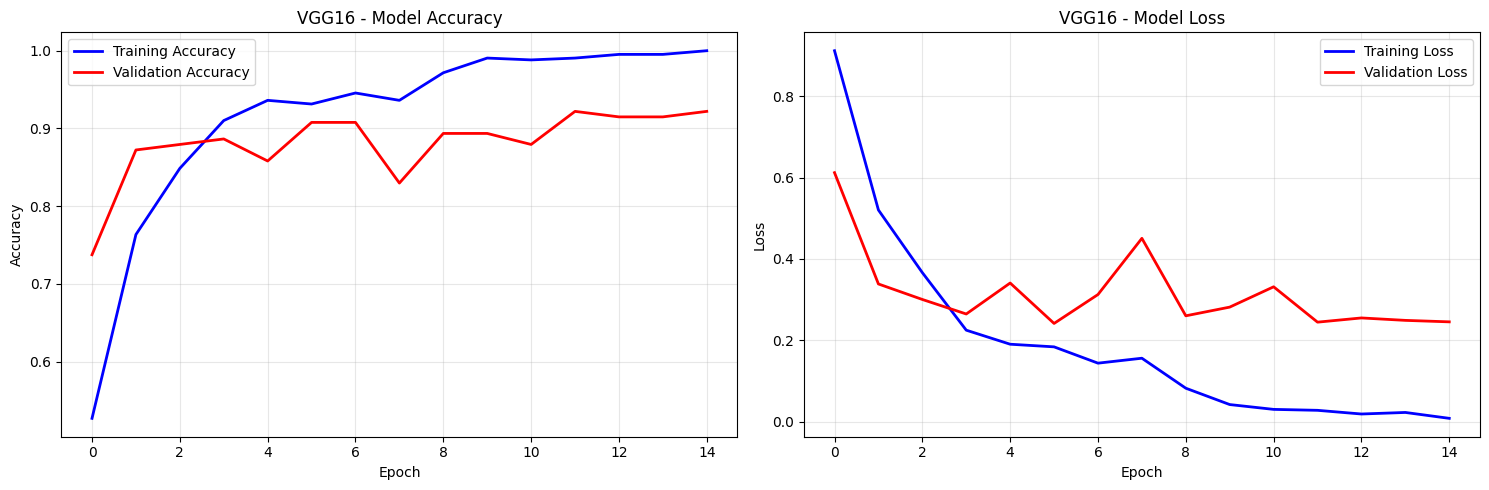


📊 VGG16 RESULTS:
Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.9220
Best Validation Accuracy: 0.9220

EVALUATING VGG16 ON TEST SET
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 684ms/step - accuracy: 0.8668 - loss: 0.4698

🎯 TEST RESULTS:
Test Accuracy: 0.8592
Test Loss: 0.4142
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 389ms/step


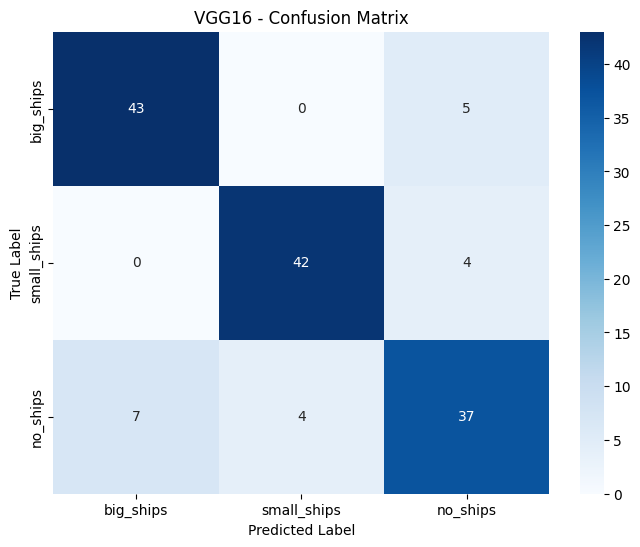


VGG16 Classification Report:
              precision    recall  f1-score   support

   big_ships       0.86      0.90      0.88        48
 small_ships       0.91      0.91      0.91        46
    no_ships       0.80      0.77      0.79        48

    accuracy                           0.86       142
   macro avg       0.86      0.86      0.86       142
weighted avg       0.86      0.86      0.86       142



In [ ]:
print("\n" + "="*60)
print("🔥 EXPERIMENT 1: VGG16 TRANSFER LEARNING")
print("="*60)

# Train VGG16
vgg16_model, vgg16_base = create_vgg16_model()
vgg16_model.summary()
history_vgg16 = train_model(vgg16_model, train_gen_basic, val_gen_basic, "vgg16", epochs=15)
val_acc_vgg16 = plot_training_history(history_vgg16, "VGG16")
test_acc_vgg16, _ = evaluate_model(vgg16_model, test_gen_basic, "VGG16", class_names)
part2_results['VGG16'] = {'val_acc': val_acc_vgg16, 'test_acc': test_acc_vgg16, 'model': vgg16_model}


🔥 EXPERIMENT 2: VGG19 TRANSFER LEARNING
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🏗️ VGG19 Transfer Learning Model
- Pre-trained on ImageNet (deeper than VGG16)
- Base model frozen
- Custom classifier: GAP → Dense(256) → Dense(3)
- Input size: 224×224
- Learning rate: 0.001


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 4, 4, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,557,443 (78.42 MB)

 Trainable params: 533,059 (2.03 MB)

 Non-trainable params: 20,024,384 (76.39 MB)


TRAINING VGG19
Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.4327 - loss: 1.1141
Epoch 1: val_accuracy improved from -inf to 0.78014, saving model to best_vgg19.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 612ms/step - accuracy: 0.4361 - loss: 1.1092 - val_accuracy: 0.7801 - val_loss: 0.6133 - learning_rate: 0.0010
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.6723 - loss: 0.6791
Epoch 2: val_accuracy improved from 0.78014 to 0.85816, saving model to best_vgg19.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 521ms/step - accuracy: 0.6742 - loss: 0.6773 - val_accuracy: 0.8582 - val_loss: 0.4497 - learning_rate: 0.0010
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.8166 - loss: 0.4806
Epoch 3: val_accuracy did not improve from 0.85816
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 493ms/step - accuracy: 0.8173 - loss: 0.4792 - val_accuracy: 0.7730 - val_loss: 0.5105 - learning_rate: 0.0010
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8396 - loss: 0.4122
Epoch 4: val_accuracy improved from 0.85816 to 0.88652, saving model to best_vgg19.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 585ms/step - accuracy: 0.8408 - loss: 0.4093 - val_accuracy: 0.8865 - val_loss: 0.3513 - learning_rate: 0.0010
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.9060 - loss: 0.2812
Epoch 5: val_accuracy did not improve from 0.88652
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 641ms/step - accuracy: 0.9058 - loss: 0.2816 - val_accuracy: 0.8865 - val_loss: 0.3704 - learning_rate: 0.0010
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9277 - loss: 0.2401
Epoch 6: val_accuracy improved from 0.88652 to 0.90780, saving model to best_vgg19.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 499ms/step - accuracy: 0.9278 - loss: 0.2390 - val_accuracy: 0.9078 - val_loss: 0.2625 - learning_rate: 0.0010
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9527 - loss: 0.1413
Epoch 7: val_accuracy did not improve from 0.90780
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 507ms/step - accuracy: 0.9528 - loss: 0.1414 - val_accuracy: 0.9007 - val_loss: 0.3039 - learning_rate: 0.0010
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9420 - loss: 0.1164
Epoch 8: val_accuracy improved from 0.90780 to 0.91489, saving model to best_vgg19.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 517ms/step - accuracy: 0.9422 - loss: 0.1164 - val_accuracy: 0.9149 - val_loss: 0.2607 - learning_rate: 0.0010
Epoch 9/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9737 - loss: 0.0887
Epoch 9: val_accuracy did not improve from 0.91489
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 508ms/step - accuracy: 0.9739 - loss: 0.0885 - val_accuracy: 0.8794 - val_loss: 0.3234 - learning_rate: 0.0010
Epoch 10/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.9695 - loss: 0.1071
Epoch 10: val_accuracy improved from 0.91489 to 0.92908, saving model to best_vgg19.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 496ms/step - accuracy: 0.9696 - loss: 0.1069 - val_accuracy: 0.9291 - val_loss: 0.2511 - learning_rate: 0.0010
Epoch 11/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.9847 - loss: 0.0601
Epoch 11: val_accuracy did not improve from 0.92908
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 517ms/step - accuracy: 0.9841 - loss: 0.0609 - val_accuracy: 0.9078 - val_loss: 0.2637 - learning_rate: 0.0010
Epoch 12/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.9769 - loss: 0.0719
Epoch 12: val_accuracy did not improve from 0.92908
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 502ms/step - accuracy: 0.9769 - loss: 0.0716 - val_accuracy: 0.9149 - val_loss: 0.2505 - learning_rate: 0.0010
Epoch 13/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.9981 - loss: 0.0294
Epoch 13: val_accuracy did not improve from 0.92908
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 569ms/step - accuracy: 0.9980 - loss: 0.0296 - val_accuracy: 0.9220 - val_loss: 0.2792 - learning_rate: 0.0010
Epoch 14/15
27/

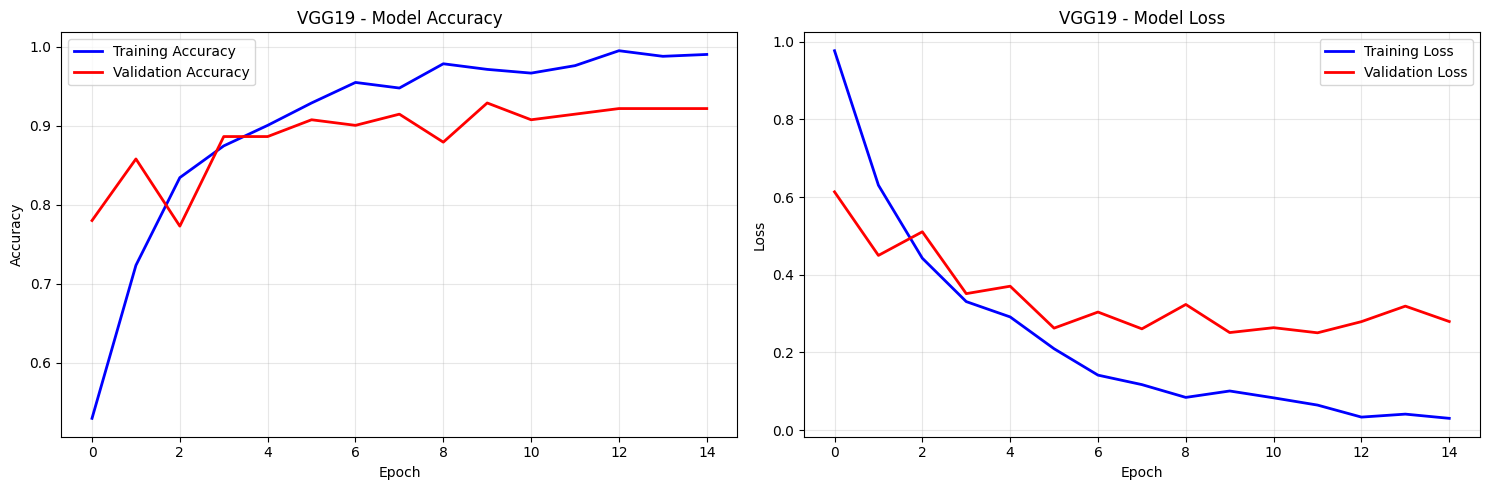


📊 VGG19 RESULTS:
Final Training Accuracy: 0.9905
Final Validation Accuracy: 0.9220
Best Validation Accuracy: 0.9291

EVALUATING VGG19 ON TEST SET
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 408ms/step - accuracy: 0.8360 - loss: 0.5401

🎯 TEST RESULTS:
Test Accuracy: 0.8521
Test Loss: 0.4851
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 517ms/step


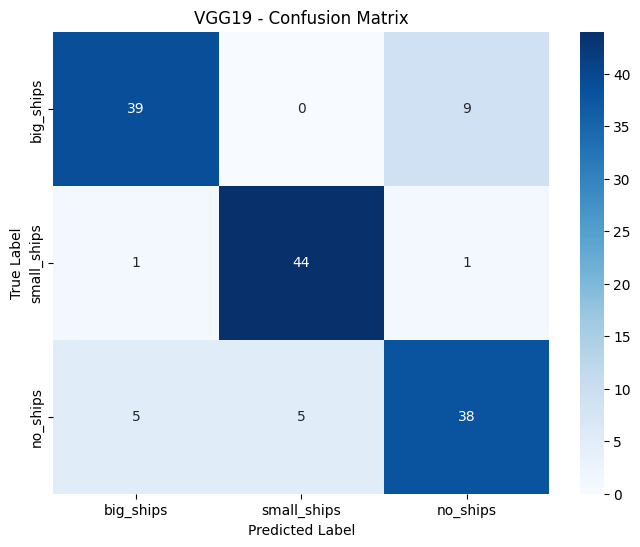


VGG19 Classification Report:
              precision    recall  f1-score   support

   big_ships       0.87      0.81      0.84        48
 small_ships       0.90      0.96      0.93        46
    no_ships       0.79      0.79      0.79        48

    accuracy                           0.85       142
   macro avg       0.85      0.85      0.85       142
weighted avg       0.85      0.85      0.85       142



In [ ]:
print("\n" + "="*60)
print("🔥 EXPERIMENT 2: VGG19 TRANSFER LEARNING")
print("="*60)

# Train VGG19
vgg19_model, vgg19_base = create_vgg19_model()
vgg19_model.summary()
history_vgg19 = train_model(vgg19_model, train_gen_basic, val_gen_basic, "vgg19", epochs=15)
val_acc_vgg19 = plot_training_history(history_vgg19, "VGG19")
test_acc_vgg19, _ = evaluate_model(vgg19_model, test_gen_basic, "VGG19", class_names)
part2_results['VGG19'] = {'val_acc': val_acc_vgg19, 'test_acc': test_acc_vgg19, 'model': vgg19_model}


🔥 EXPERIMENT 3: EfficientNetB0 TRANSFER LEARNING
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🏗️ EfficientNetB0 Transfer Learning Model
- Pre-trained on ImageNet (state-of-the-art efficiency)
- Base model frozen
- Custom classifier: GAP → Dense(128) → Dense(64) → Dense(3)
- Input size: 224×224
- Learning rate: 0.0001 (lower for stability)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │     1,310,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,369,062 (20.48 MB)

 Trainable params: 1,319,491 (5.03 MB)

 Non-trainable params: 4,049,571 (15.45 MB)


TRAINING EFFICIENTNET
Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.3344 - loss: 1.1593
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to best_efficientnet.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.3337 - loss: 1.1601 - val_accuracy: 0.3333 - val_loss: 1.0994 - learning_rate: 1.0000e-04
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.2823 - loss: 1.1127
Epoch 2: val_accuracy did not improve from 0.33333
27/27 ━━━━━━━━━━━━━━━━━━━━ 49s 495ms/step - accuracy: 0.2822 - loss: 1.1124 - val_accuracy: 0.3333 - val_loss: 1.0986 - learning_rate: 1.0000e-04
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.4061 - loss: 1.0987
Epoch 3: val_accuracy did not improve from 0.33333
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 460ms/step - accuracy: 0.4047 - loss: 1.0987 - val_accuracy: 0.3333 - val_loss: 1.0986 - learning_rate: 1.0000e-04
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.3247 - loss: 1.0987
Epoch 4: val_accuracy did not improve from 0.33333
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 504ms/step - accuracy: 0.3251 - loss: 1.0987 - val_accuracy: 0.3333 - val_loss: 1.0986 - learning_rate: 1.0000e-04
Epoch 5/

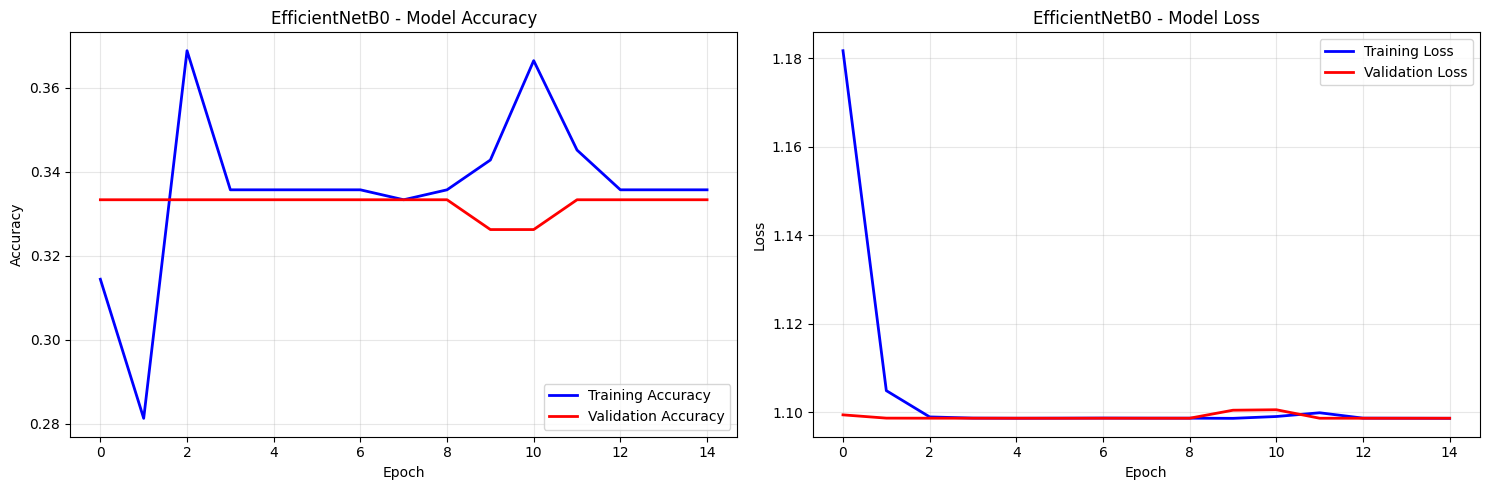


📊 EfficientNetB0 RESULTS:
Final Training Accuracy: 0.3357
Final Validation Accuracy: 0.3333
Best Validation Accuracy: 0.3333

EVALUATING EFFICIENTNETB0 ON TEST SET
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 886ms/step - accuracy: 0.1123 - loss: 1.0993

🎯 TEST RESULTS:
Test Accuracy: 0.3380
Test Loss: 1.0986
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 973ms/step


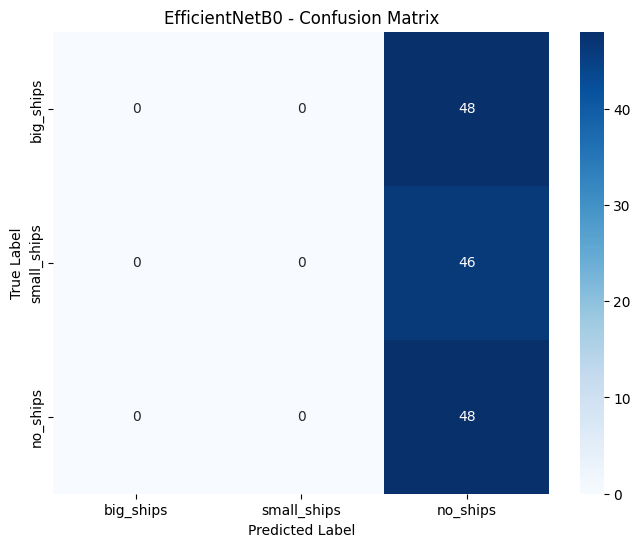


EfficientNetB0 Classification Report:
              precision    recall  f1-score   support

   big_ships       0.00      0.00      0.00        48
 small_ships       0.00      0.00      0.00        46
    no_ships       0.34      1.00      0.51        48

    accuracy                           0.34       142
   macro avg       0.11      0.33      0.17       142
weighted avg       0.11      0.34      0.17       142



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print("\n" + "="*60)
print("🔥 EXPERIMENT 3: EfficientNetB0 TRANSFER LEARNING")
print("="*60)

# Train EfficientNetB0
efficientnet_model, efficientnet_base = create_efficientnet_model()
efficientnet_model.summary()
history_efficientnet = train_model(efficientnet_model, train_gen_basic, val_gen_basic, "efficientnet", epochs=15)
val_acc_efficientnet = plot_training_history(history_efficientnet, "EfficientNetB0")
test_acc_efficientnet, _ = evaluate_model(efficientnet_model, test_gen_basic, "EfficientNetB0", class_names)
part2_results['EfficientNetB0'] = {'val_acc': val_acc_efficientnet, 'test_acc': test_acc_efficientnet, 'model': efficientnet_model}



🔥 EXPERIMENT 4: MobileNetV2 TRANSFER LEARNING
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🏗️ MobileNetV2 Transfer Learning Model
- Pre-trained on ImageNet (lightweight architecture)
- Base model frozen
- Custom classifier: GAP → Dense(128) → Dense(64) → Dense(3)
- Input size: 224×224
- Learning rate: 0.001


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │     1,310,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,577,475 (13.65 MB)

 Trainable params: 1,319,491 (5.03 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


TRAINING MOBILENET
Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.5807 - loss: 1.3513
Epoch 1: val_accuracy improved from -inf to 0.90071, saving model to best_mobilenet.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 888ms/step - accuracy: 0.5841 - loss: 1.3390 - val_accuracy: 0.9007 - val_loss: 0.3079 - learning_rate: 0.0010
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.8902 - loss: 0.2686
Epoch 2: val_accuracy improved from 0.90071 to 0.91489, saving model to best_mobilenet.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 497ms/step - accuracy: 0.8899 - loss: 0.2727 - val_accuracy: 0.9149 - val_loss: 0.3812 - learning_rate: 0.0010
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9633 - loss: 0.1111
Epoch 3: val_accuracy did not improve from 0.91489
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 494ms/step - accuracy: 0.9628 - loss: 0.1137 - val_accuracy: 0.9078 - val_loss: 0.4736 - learning_rate: 0.0010
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9543 - loss: 0.1509
Epoch 4: val_accuracy improved from 0.91489 to 0.92199, saving model to best_mobilenet.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 497ms/step - accuracy: 0.9541 - loss: 0.1513 - val_accuracy: 0.9220 - val_loss: 0.3579 - learning_rate: 0.0010
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9681 - loss: 0.1008
Epoch 5: val_accuracy improved from 0.92199 to 0.95035, saving model to best_mobilenet.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 509ms/step - accuracy: 0.9680 - loss: 0.1013 - val_accuracy: 0.9504 - val_loss: 0.3057 - learning_rate: 0.0010
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9628 - loss: 0.0860
Epoch 6: val_accuracy did not improve from 0.95035
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 503ms/step - accuracy: 0.9635 - loss: 0.0847 - val_accuracy: 0.9433 - val_loss: 0.3713 - learning_rate: 0.0010
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 1.0000 - loss: 0.0125
Epoch 7: val_accuracy did not improve from 0.95035
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 487ms/step - accuracy: 1.0000 - loss: 0.0126 - val_accuracy: 0.9362 - val_loss: 0.3410 - learning_rate: 0.0010
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9852 - loss: 0.0394
Epoch 8: val_accuracy did not improve from 0.95035
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 491ms/step - accuracy: 0.9854 - loss: 0.0391 - val_accuracy: 0.9291 - val_loss: 0.3871 - learning_rate: 0.0010
Epoch 9/15
27/27 ━━━━


Epoch 15: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 497ms/step - accuracy: 0.9882 - loss: 0.0513 - val_accuracy: 0.9574 - val_loss: 0.3636 - learning_rate: 3.0000e-04


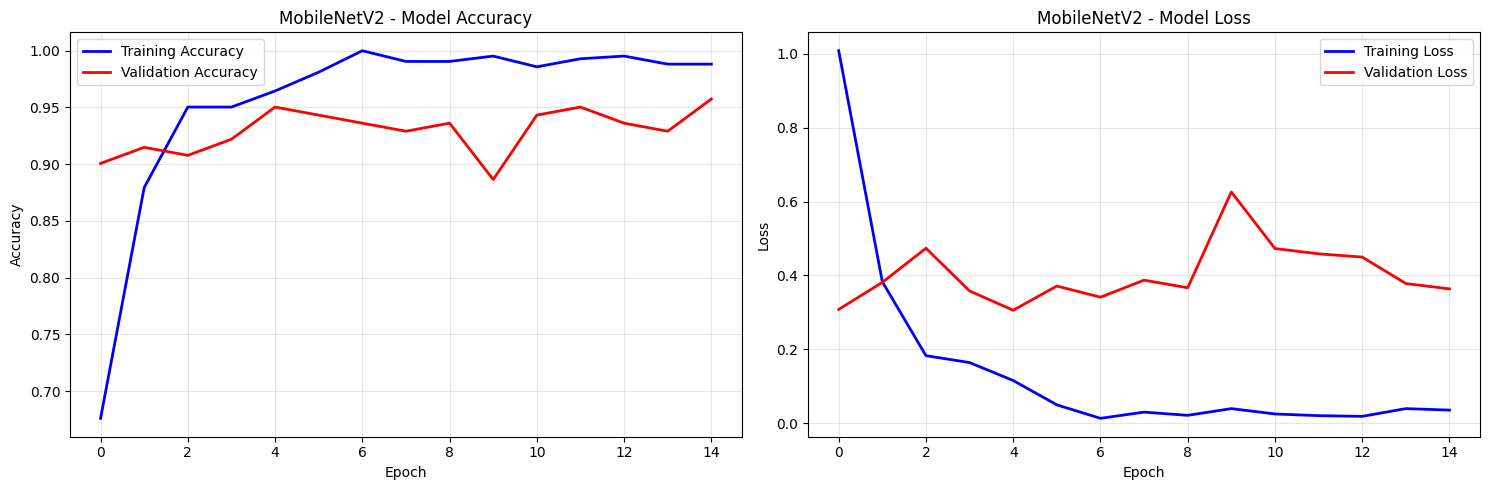


📊 MobileNetV2 RESULTS:
Final Training Accuracy: 0.9882
Final Validation Accuracy: 0.9574
Best Validation Accuracy: 0.9574

EVALUATING MOBILENETV2 ON TEST SET
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 747ms/step - accuracy: 0.9173 - loss: 0.5521

🎯 TEST RESULTS:
Test Accuracy: 0.9155
Test Loss: 0.5310
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 656ms/step


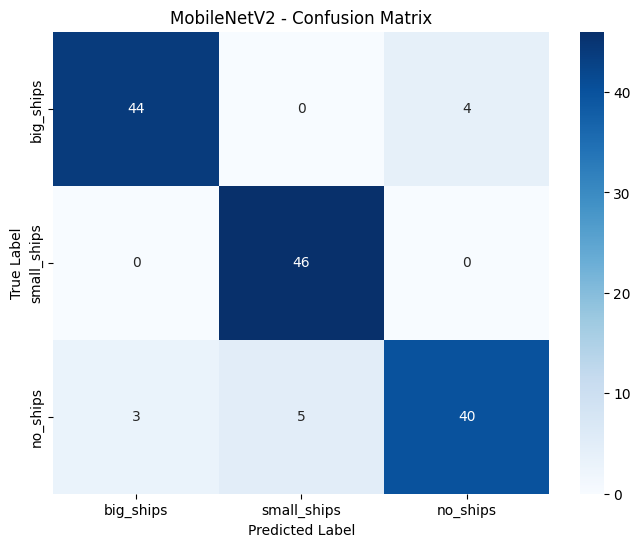


MobileNetV2 Classification Report:
              precision    recall  f1-score   support

   big_ships       0.94      0.92      0.93        48
 small_ships       0.90      1.00      0.95        46
    no_ships       0.91      0.83      0.87        48

    accuracy                           0.92       142
   macro avg       0.92      0.92      0.91       142
weighted avg       0.92      0.92      0.91       142



In [ ]:
print("\n" + "="*60)
print("🔥 EXPERIMENT 4: MobileNetV2 TRANSFER LEARNING")
print("="*60)

# Train MobileNetV2
mobilenet_model, mobilenet_base = create_mobilenet_model()
mobilenet_model.summary()
history_mobilenet = train_model(mobilenet_model, train_gen_basic, val_gen_basic, "mobilenet", epochs=15)
val_acc_mobilenet = plot_training_history(history_mobilenet, "MobileNetV2")
test_acc_mobilenet, _ = evaluate_model(mobilenet_model, test_gen_basic, "MobileNetV2", class_names)
part2_results['MobileNetV2'] = {'val_acc': val_acc_mobilenet, 'test_acc': test_acc_mobilenet, 'model': mobilenet_model}


🔥 EXPERIMENT 5: ResNet50 TRANSFER LEARNING (For Comparison)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🏗️ ResNet50 Transfer Learning Model
- Pre-trained on ImageNet
- Base model frozen
- Custom classifier: GAP → Dense(256) → Dense(128) → Dense(3)
- Learning rate: 0.001


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,719,043 (90.48 MB)

 Trainable params: 131,331 (513.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)


TRAINING RESNET50
Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.3391 - loss: 1.1784
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to best_resnet50.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 36s 951ms/step - accuracy: 0.3397 - loss: 1.1782 - val_accuracy: 0.3333 - val_loss: 1.1096 - learning_rate: 0.0010
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.3141 - loss: 1.1422
Epoch 2: val_accuracy did not improve from 0.33333
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 493ms/step - accuracy: 0.3148 - loss: 1.1412 - val_accuracy: 0.3333 - val_loss: 1.0864 - learning_rate: 0.0010
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.3674 - loss: 1.0943
Epoch 3: val_accuracy improved from 0.33333 to 0.34752, saving model to best_resnet50.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 521ms/step - accuracy: 0.3669 - loss: 1.0948 - val_accuracy: 0.3475 - val_loss: 1.0807 - learning_rate: 0.0010
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.3571 - loss: 1.0908
Epoch 4: val_accuracy improved from 0.34752 to 0.39007, saving model to best_resnet50.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 519ms/step - accuracy: 0.3571 - loss: 1.0911 - val_accuracy: 0.3901 - val_loss: 1.0808 - learning_rate: 0.0010
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.3506 - loss: 1.1034
Epoch 5: val_accuracy improved from 0.39007 to 0.43262, saving model to best_resnet50.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 517ms/step - accuracy: 0.3509 - loss: 1.1034 - val_accuracy: 0.4326 - val_loss: 1.0742 - learning_rate: 0.0010
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.4065 - loss: 1.0789
Epoch 6: val_accuracy did not improve from 0.43262
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 519ms/step - accuracy: 0.4056 - loss: 1.0792 - val_accuracy: 0.3404 - val_loss: 1.0713 - learning_rate: 0.0010
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.4208 - loss: 1.0741
Epoch 7: val_accuracy did not improve from 0.43262
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 506ms/step - accuracy: 0.4206 - loss: 1.0741 - val_accuracy: 0.3404 - val_loss: 1.0750 - learning_rate: 0.0010
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.3562 - loss: 1.0836
Epoch 8: val_accuracy improved from 0.43262 to 0.53191, saving model to best_resnet50.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 532ms/step - accuracy: 0.3577 - loss: 1.0833 - val_accuracy: 0.5319 - val_loss: 1.0592 - learning_rate: 0.0010
Epoch 9/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.4515 - loss: 1.0753
Epoch 9: val_accuracy did not improve from 0.53191
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 513ms/step - accuracy: 0.4507 - loss: 1.0753 - val_accuracy: 0.3830 - val_loss: 1.0587 - learning_rate: 0.0010
Epoch 10/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.4365 - loss: 1.0675
Epoch 10: val_accuracy did not improve from 0.53191
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 486ms/step - accuracy: 0.4372 - loss: 1.0674 - val_accuracy: 0.4539 - val_loss: 1.0524 - learning_rate: 0.0010
Epoch 11/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.4294 - loss: 1.0648
Epoch 11: val_accuracy improved from 0.53191 to 0.60284, saving model to best_resnet50.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 524ms/step - accuracy: 0.4294 - loss: 1.0645 - val_accuracy: 0.6028 - val_loss: 1.0444 - learning_rate: 0.0010
Epoch 12/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.4748 - loss: 1.0435
Epoch 12: val_accuracy did not improve from 0.60284
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 500ms/step - accuracy: 0.4741 - loss: 1.0437 - val_accuracy: 0.4184 - val_loss: 1.0444 - learning_rate: 0.0010
Epoch 13/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.4422 - loss: 1.0556
Epoch 13: val_accuracy did not improve from 0.60284
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 592ms/step - accuracy: 0.4422 - loss: 1.0554 - val_accuracy: 0.5390 - val_loss: 1.0499 - learning_rate: 0.0010
Epoch 14/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.4407 - loss: 1.0520
Epoch 14: val_accuracy did not improve from 0.60284
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 476ms/step - accuracy: 0.4401 - loss: 1.0522 - val_accuracy: 0.3404 - val_loss: 1.0378 - learning_rate: 0.0010
Epoch 15/15
27/

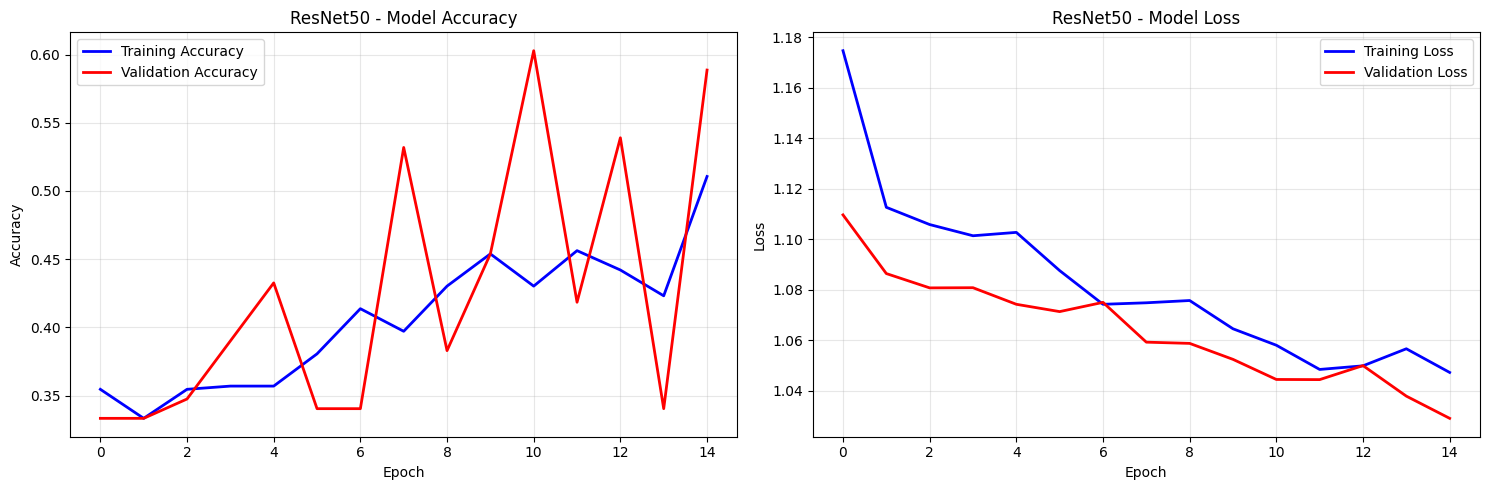


📊 ResNet50 RESULTS:
Final Training Accuracy: 0.5106
Final Validation Accuracy: 0.5887
Best Validation Accuracy: 0.6028

EVALUATING RESNET50 ON TEST SET
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 751ms/step - accuracy: 0.4912 - loss: 1.0514

🎯 TEST RESULTS:
Test Accuracy: 0.5775
Test Loss: 1.0385
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 852ms/step


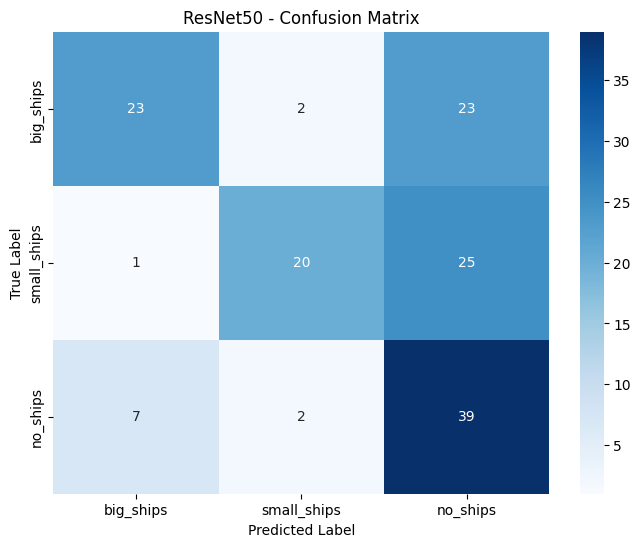


ResNet50 Classification Report:
              precision    recall  f1-score   support

   big_ships       0.74      0.48      0.58        48
 small_ships       0.83      0.43      0.57        46
    no_ships       0.45      0.81      0.58        48

    accuracy                           0.58       142
   macro avg       0.67      0.58      0.58       142
weighted avg       0.67      0.58      0.58       142



In [ ]:
print("\n" + "="*60)
print("🔥 EXPERIMENT 5: ResNet50 TRANSFER LEARNING (For Comparison)")
print("="*60)

# Train ResNet50 (keep for comparison)
resnet50_model, resnet50_base = create_resnet50_model()
resnet50_model.summary()
history_resnet50 = train_model(resnet50_model, train_gen_basic, val_gen_basic, "resnet50", epochs=15)
val_acc_resnet50 = plot_training_history(history_resnet50, "ResNet50")
test_acc_resnet50, _ = evaluate_model(resnet50_model, test_gen_basic, "ResNet50", class_names)
part2_results['ResNet50'] = {'val_acc': val_acc_resnet50, 'test_acc': test_acc_resnet50, 'model': resnet50_model}



📊 PART 2 RESULTS: TRANSFER LEARNING COMPARISON


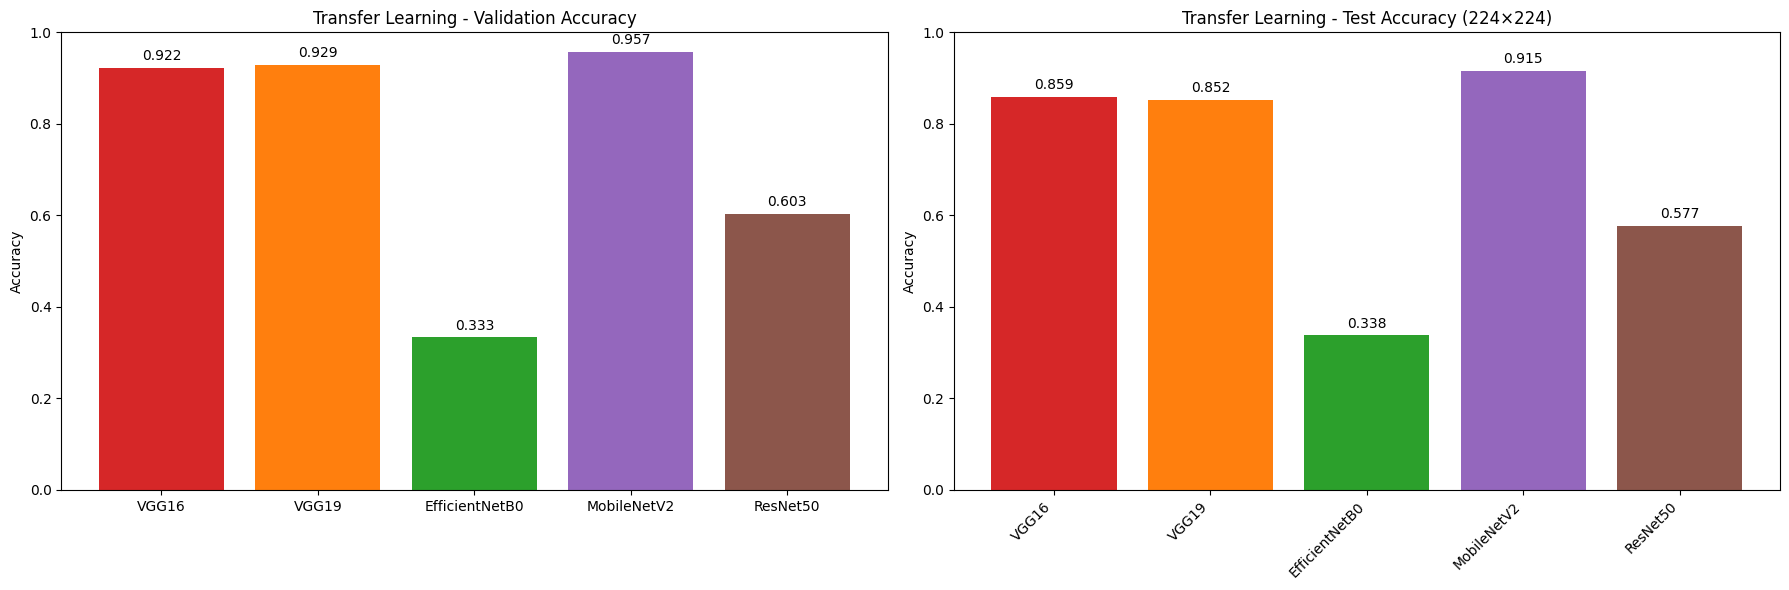


🏆 PART 2 TRANSFER LEARNING RESULTS:
--------------------------------------------------
VGG16:
  Validation Accuracy: 0.9220
  Test Accuracy: 0.8592

VGG19:
  Validation Accuracy: 0.9291
  Test Accuracy: 0.8521

EfficientNetB0:
  Validation Accuracy: 0.3333
  Test Accuracy: 0.3380

MobileNetV2:
  Validation Accuracy: 0.9574
  Test Accuracy: 0.9155

ResNet50:
  Validation Accuracy: 0.6028
  Test Accuracy: 0.5775

🥇 BEST TRANSFER MODEL: MobileNetV2
   Validation Accuracy: 0.9574
   Test Accuracy: 0.9155

📊 TRANSFER LEARNING RANKING:
1. MobileNetV2: 0.9574
2. VGG16: 0.9220
3. VGG19: 0.9291
4. ResNet50: 0.6028
5. EfficientNetB0: 0.3333

✅ Part 2 Complete! Transfer learning models tested


In [ ]:
# Compare Transfer Learning Results
print("\n" + "="*60)
print("📊 PART 2 RESULTS: TRANSFER LEARNING COMPARISON")
print("="*60)

# Create comparison visualization
models = list(part2_results.keys())
val_accs = [part2_results[model]['val_acc'] for model in models]
test_accs = [part2_results[model]['test_acc'] for model in models]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Validation accuracy comparison
colors = ['#d62728', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b']  # Added more colors
bars1 = ax1.bar(models, val_accs, color=colors[:len(models)])
ax1.set_title('Transfer Learning - Validation Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
for bar, acc in zip(bars1, val_accs):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')

# Test accuracy comparison
bars2 = ax2.bar(models, test_accs, color=colors[:len(models)])
ax2.set_title('Transfer Learning - Test Accuracy (224×224)')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)
for bar, acc in zip(bars2, test_accs):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n🏆 PART 2 TRANSFER LEARNING RESULTS:")
print("-" * 50)
for model_name in part2_results:
    val_acc = part2_results[model_name]['val_acc']
    test_acc = part2_results[model_name]['test_acc']
    print(f"{model_name}:")
    print(f"  Validation Accuracy: {val_acc:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print()

# Find best transfer learning models
best_transfer_model = max(part2_results.keys(), key=lambda x: part2_results[x]['test_acc'])
transfer_ranking = sorted(part2_results.items(), key=lambda x: x[1]['test_acc'], reverse=True)

print(f"🥇 BEST TRANSFER MODEL: {best_transfer_model}")
print(f"   Validation Accuracy: {part2_results[best_transfer_model]['val_acc']:.4f}")
print(f"   Test Accuracy: {part2_results[best_transfer_model]['test_acc']:.4f}")

print(f"\n📊 TRANSFER LEARNING RANKING:")
for i, (model_name, results) in enumerate(transfer_ranking, 1):
    print(f"{i}. {model_name}: {results['val_acc']:.4f}")

print(f"\n✅ Part 2 Complete! Transfer learning models tested")

Part 3 : Data Augmentation with the best Custom CNN.

In [ ]:
# Create augmented data generators
print("🔄 Creating augmented data generators...")
train_gen_aug, val_gen_aug, test_gen_aug = create_augmented_generators(
    train_dir, val_dir, test_dir, (IMG_HEIGHT, IMG_WIDTH), BATCH_SIZE)

🔄 Creating augmented data generators...
Found 423 images belonging to 3 classes.
Found 141 images belonging to 3 classes.
Found 142 images belonging to 3 classes.


In [ ]:
print("Data augmentation applied:")
print("- Rotation: ±25°")
print("- Width/Height shift: ±15%")
print("- Shear transformation: ±15%")
print("- Zoom: ±15%")
print("- Horizontal flip: Yes")
print("- Brightness variation: 90%-110%")

Data augmentation applied:
- Rotation: ±25°
- Width/Height shift: ±15%
- Shear transformation: ±15%
- Zoom: ±15%
- Horizontal flip: Yes
- Brightness variation: 90%-110%


In [ ]:
try:
    best_custom_model
    best_custom_info
    print(f"✅ Using best model from Part 1: {best_custom_model}")
except NameError:
    print("⚠️ Part 1 results not found. Using CNN Architecture 1 as default.")
    # Fallback: use Architecture 1 if Part 1 wasn't completed
    best_custom_model = 'CNN Architecture 2'
    # Create mock results for fallback
    part1_results = {
        'CNN Architecture 1': {'val_acc': 0.6, 'test_acc': 0.55, 'model': None}
    }
    best_custom_info = part1_results[best_custom_model]

⚠️ Part 1 results not found. Using CNN Architecture 1 as default.


KeyError: 'CNN Architecture 2'

In [ ]:
best_model_name = "CNN Architecture 2"

In [ ]:
def recreate_best_custom_model():
    """Recreate the best performing custom architecture from Part 1"""
    if 'Architecture 1' in best_model_name:
        return create_cnn_architecture_1()
    elif 'Architecture 2' in best_model_name:
        return create_cnn_architecture_2()
    elif 'Architecture 3' in best_model_name:
        return create_cnn_architecture_3()
    else:  # Architecture 4
        return create_cnn_architecture_4()


🔥 TRAINING CNN ARCHITECTURE 2 WITH DATA AUGMENTATION


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,149,059 (65.42 MB)

 Trainable params: 17,149,059 (65.42 MB)

 Non-trainable params: 0 (0.00 B)


TRAINING BEST_CUSTOM_AUGMENTED


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.3913 - loss: 1.2828
Epoch 1: val_accuracy improved from -inf to 0.61702, saving model to best_best_custom_augmented.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 700ms/step - accuracy: 0.3939 - loss: 1.2775 - val_accuracy: 0.6170 - val_loss: 0.9343 - learning_rate: 0.0010
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.5924 - loss: 0.9828
Epoch 2: val_accuracy did not improve from 0.61702
27/27 ━━━━━━━━━━━━━━━━━━━━ 35s 558ms/step - accuracy: 0.5926 - loss: 0.9814 - val_accuracy: 0.5461 - val_loss: 0.9076 - learning_rate: 0.0010
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.6280 - loss: 0.8618
Epoch 3: val_accuracy improved from 0.61702 to 0.66667, saving model to best_best_custom_augmented.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 589ms/step - accuracy: 0.6281 - loss: 0.8626 - val_accuracy: 0.6667 - val_loss: 0.7205 - learning_rate: 0.0010
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.6214 - loss: 0.8424
Epoch 4: val_accuracy improved from 0.66667 to 0.72340, saving model to best_best_custom_augmented.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 597ms/step - accuracy: 0.6226 - loss: 0.8422 - val_accuracy: 0.7234 - val_loss: 0.7433 - learning_rate: 0.0010
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.7087 - loss: 0.7010
Epoch 5: val_accuracy improved from 0.72340 to 0.80142, saving model to best_best_custom_augmented.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 593ms/step - accuracy: 0.7086 - loss: 0.7013 - val_accuracy: 0.8014 - val_loss: 0.6123 - learning_rate: 0.0010
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.6942 - loss: 0.6902
Epoch 6: val_accuracy did not improve from 0.80142
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 559ms/step - accuracy: 0.6944 - loss: 0.6899 - val_accuracy: 0.7021 - val_loss: 0.7166 - learning_rate: 0.0010
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.7217 - loss: 0.6784
Epoch 7: val_accuracy did not improve from 0.80142
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 572ms/step - accuracy: 0.7225 - loss: 0.6765 - val_accuracy: 0.7518 - val_loss: 0.6271 - learning_rate: 0.0010
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.7060 - loss: 0.6898
Epoch 8: val_accuracy did not improve from 0.80142
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 545ms/step - accuracy: 0.7074 - loss: 0.6875 - val_accuracy: 0.7518 - val_loss: 0.5445 - learning_rate: 0.0010
Epoch 9/30
27/27 ━━━━


Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 589ms/step - accuracy: 0.7064 - loss: 0.6311 - val_accuracy: 0.8085 - val_loss: 0.5143 - learning_rate: 0.0010
Epoch 16/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.7727 - loss: 0.5474
Epoch 16: val_accuracy did not improve from 0.80851
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 557ms/step - accuracy: 0.7742 - loss: 0.5442 - val_accuracy: 0.8085 - val_loss: 0.4581 - learning_rate: 3.0000e-04
Epoch 17/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.8262 - loss: 0.3947
Epoch 17: val_accuracy did not improve from 0.80851
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 568ms/step - accuracy: 0.8263 - loss: 0.3951 - val_accuracy: 0.7801 - val_loss: 0.4803 - learning_rate: 3.0000e-04
Epoch 18/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.8435 - loss: 0.3919
Epoch 18: val_accuracy improved from 0.80851 to 0.82270, saving model to best_best_custom_augmented.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 600ms/step - accuracy: 0.8432 - loss: 0.3925 - val_accuracy: 0.8227 - val_loss: 0.4694 - learning_rate: 3.0000e-04
Epoch 19/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.8207 - loss: 0.4149
Epoch 19: val_accuracy did not improve from 0.82270
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 552ms/step - accuracy: 0.8207 - loss: 0.4152 - val_accuracy: 0.7730 - val_loss: 0.4958 - learning_rate: 3.0000e-04
Epoch 20/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.8600 - loss: 0.3584
Epoch 20: val_accuracy did not improve from 0.82270
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 575ms/step - accuracy: 0.8595 - loss: 0.3600 - val_accuracy: 0.8014 - val_loss: 0.4887 - learning_rate: 3.0000e-04
Epoch 21/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.8495 - loss: 0.3427
Epoch 21: val_accuracy did not improve from 0.82270

Epoch 21: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 667ms/step - accuracy: 0.8497 - loss

27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 702ms/step - accuracy: 0.8754 - loss: 0.3443 - val_accuracy: 0.8298 - val_loss: 0.4690 - learning_rate: 9.0000e-05
Epoch 24/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.8874 - loss: 0.2908
Epoch 24: val_accuracy did not improve from 0.82979
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 577ms/step - accuracy: 0.8867 - loss: 0.2917 - val_accuracy: 0.8085 - val_loss: 0.4828 - learning_rate: 9.0000e-05
Epoch 25/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.8562 - loss: 0.3155
Epoch 25: val_accuracy did not improve from 0.82979
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 579ms/step - accuracy: 0.8567 - loss: 0.3157 - val_accuracy: 0.8227 - val_loss: 0.4694 - learning_rate: 9.0000e-05
Epoch 26/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.8898 - loss: 0.3079
Epoch 26: val_accuracy did not improve from 0.82979

Epoch 26: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 585ms/step - accuracy: 0.8893 - loss

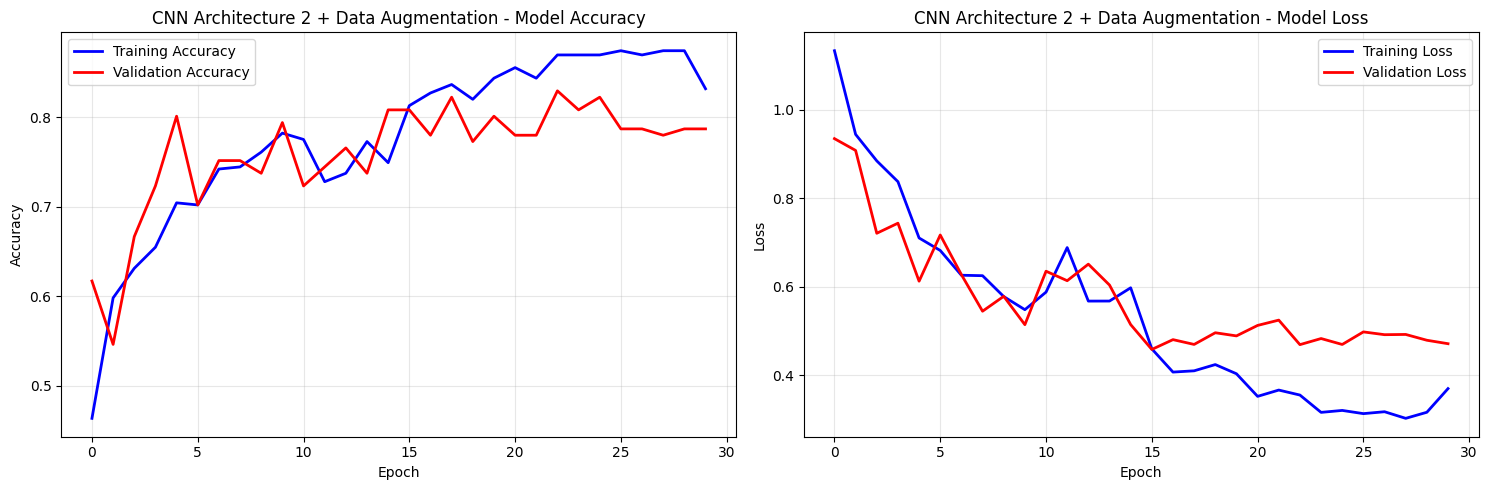


📊 CNN Architecture 2 + Data Augmentation RESULTS:
Final Training Accuracy: 0.8322
Final Validation Accuracy: 0.7872
Best Validation Accuracy: 0.8298

EVALUATING CNN ARCHITECTURE 2 + AUGMENTATION ON TEST SET
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 376ms/step - accuracy: 0.8847 - loss: 0.3434

🎯 TEST RESULTS:
Test Accuracy: 0.8592
Test Loss: 0.4437
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 452ms/step


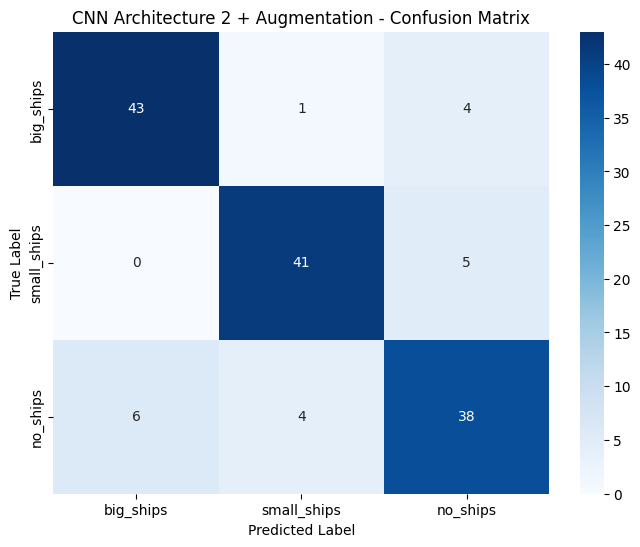


CNN Architecture 2 + Augmentation Classification Report:
              precision    recall  f1-score   support

   big_ships       0.88      0.90      0.89        48
 small_ships       0.89      0.89      0.89        46
    no_ships       0.81      0.79      0.80        48

    accuracy                           0.86       142
   macro avg       0.86      0.86      0.86       142
weighted avg       0.86      0.86      0.86       142



In [ ]:
print(f"\n🔥 TRAINING {best_custom_model.upper()} WITH DATA AUGMENTATION")
print("="*60)

# Train the best custom model with augmentation
best_model_aug = recreate_best_custom_model()
best_model_aug.summary()

# Train with more epochs since augmentation requires longer training
history_aug = train_model(best_model_aug, train_gen_aug, val_gen_aug, "best_custom_augmented", epochs=30)
val_acc_aug = plot_training_history(history_aug, f"{best_custom_model} + Data Augmentation")
test_acc_aug, _ = evaluate_model(best_model_aug, test_gen_aug, f"{best_custom_model} + Augmentation", class_names)

In [ ]:
# Compare with and without augmentation
print("\n" + "="*60)
print("📊 PART 3 RESULTS: IMPACT OF DATA AUGMENTATION ON CUSTOM CNN")
print("="*60)

# Visualization comparing with/without augmentation
comparison_models = [best_custom_model, f"{best_custom_model} + Augmentation"]
comparison_val_accs = [best_custom_info['val_acc'], val_acc_aug]
comparison_test_accs = [best_custom_info['test_acc'], test_acc_aug]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Validation accuracy comparison
bars1 = ax1.bar(comparison_models, comparison_val_accs, color=['#1f77b4', '#2ca02c'])
ax1.set_title('Best Custom CNN: Before vs After Augmentation (Validation)')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
for bar, acc in zip(bars1, comparison_val_accs):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')

# Test accuracy comparison
bars2 = ax2.bar(comparison_models, comparison_test_accs, color=['#1f77b4', '#2ca02c'])
ax2.set_title('Best Custom CNN: Before vs After Augmentation (Test)')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)
for bar, acc in zip(bars2, comparison_test_accs):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

# Calculate improvement
val_improvement = val_acc_aug - best_custom_info['val_acc']
test_improvement = test_acc_aug - best_custom_info['test_acc']

print(f"\n🎯 PART 3 AUGMENTATION IMPACT ANALYSIS:")
print("-" * 40)
print(f"Original {best_custom_model}:")
print(f"  Validation Accuracy: {best_custom_info['val_acc']:.4f}")
print(f"  Test Accuracy: {best_custom_info['test_acc']:.4f}")
print(f"\nWith Data Augmentation:")
print(f"  Validation Accuracy: {val_acc_aug:.4f} ({val_improvement:+.4f})")
print(f"  Test Accuracy: {test_acc_aug:.4f} ({test_improvement:+.4f})")

if test_improvement > 0:
    print(f"\n✅ Data augmentation IMPROVED custom CNN performance!")
    print(f"   Test accuracy increased by {test_improvement:.4f}")
else:
    print(f"\n⚠️ Data augmentation showed mixed results on custom CNN")
    print(f"   Consider adjusting augmentation parameters")

print(f"\n✅ Part 3 Complete! Best custom CNN with augmentation achieved {test_acc_aug:.4f} test accuracy")


📊 PART 3 RESULTS: IMPACT OF DATA AUGMENTATION ON CUSTOM CNN


NameError: name 'best_custom_info' is not defined

Part 4 : Data Augmentation with Transfer Learning

In [ ]:
part4_results = {}



🔥 EXPERIMENT 1: VGG16 WITH DATA AUGMENTATION

🏗️ VGG16 Transfer Learning Model
- Pre-trained on ImageNet
- Base model frozen
- Custom classifier: GAP → Dense(256) → Dense(3)
- Learning rate: 0.001

TRAINING VGG16_AUGMENTED
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.4350 - loss: 1.1442
Epoch 1: val_accuracy improved from -inf to 0.75177, saving model to best_vgg16_augmented.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 685ms/step - accuracy: 0.4374 - loss: 1.1398 - val_accuracy: 0.7518 - val_loss: 0.6318 - learning_rate: 0.0010
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.6759 - loss: 0.7047
Epoch 2: val_accuracy did not improve from 0.75177
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 586ms/step - accuracy: 0.6773 - loss: 0.7028 - val_accuracy: 0.6596 - val_loss: 0.6944 - learning_rate: 0.0010
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.7744 - loss: 0.6488
Epoch 3: val_accuracy improved from 0.75177 to 0.86525, saving model to best_vgg16_augmented.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 618ms/step - accuracy: 0.7749 - loss: 0.6465 - val_accuracy: 0.8652 - val_loss: 0.3394 - learning_rate: 0.0010
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.8134 - loss: 0.4791
Epoch 4: val_accuracy improved from 0.86525 to 0.88652, saving model to best_vgg16_augmented.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 588ms/step - accuracy: 0.8138 - loss: 0.4793 - val_accuracy: 0.8865 - val_loss: 0.3153 - learning_rate: 0.0010
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.8279 - loss: 0.3959
Epoch 5: val_accuracy did not improve from 0.88652
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 584ms/step - accuracy: 0.8281 - loss: 0.3962 - val_accuracy: 0.8794 - val_loss: 0.3722 - learning_rate: 0.0010
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.8811 - loss: 0.3629
Epoch 6: val_accuracy did not improve from 0.88652
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 588ms/step - accuracy: 0.8813 - loss: 0.3610 - val_accuracy: 0.8865 - val_loss: 0.3101 - learning_rate: 0.0010
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.8630 - loss: 0.3487
Epoch 7: val_accuracy did not improve from 0.88652
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 564ms/step - accuracy: 0.8624 - loss: 0.3495 - val_accuracy: 0.8511 - val_loss: 0.3542 - learning_rate: 0.0010
Epoch 8/20
27/27 ━━━━

27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 574ms/step - accuracy: 0.9185 - loss: 0.2391 - val_accuracy: 0.8936 - val_loss: 0.2556 - learning_rate: 0.0010
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.9276 - loss: 0.2216
Epoch 11: val_accuracy did not improve from 0.89362
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 571ms/step - accuracy: 0.9278 - loss: 0.2205 - val_accuracy: 0.8865 - val_loss: 0.2574 - learning_rate: 0.0010
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.9305 - loss: 0.2006
Epoch 12: val_accuracy did not improve from 0.89362
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 583ms/step - accuracy: 0.9302 - loss: 0.2014 - val_accuracy: 0.8511 - val_loss: 0.2865 - learning_rate: 0.0010
Epoch 13/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.9470 - loss: 0.1704
Epoch 13: val_accuracy did not improve from 0.89362
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 590ms/step - accuracy: 0.9464 - loss: 0.1711 - val_accuracy: 0.8582 - val_loss: 0.3215 - learning_rate: 0.0010
Epoch 14/20
27/

27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 678ms/step - accuracy: 0.9182 - loss: 0.1990 - val_accuracy: 0.9007 - val_loss: 0.2326 - learning_rate: 0.0010
Epoch 15/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.9524 - loss: 0.1362
Epoch 15: val_accuracy improved from 0.90071 to 0.90780, saving model to best_vgg16_augmented.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 587ms/step - accuracy: 0.9527 - loss: 0.1355 - val_accuracy: 0.9078 - val_loss: 0.3117 - learning_rate: 0.0010
Epoch 16/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.9354 - loss: 0.1236
Epoch 16: val_accuracy did not improve from 0.90780
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 603ms/step - accuracy: 0.9351 - loss: 0.1242 - val_accuracy: 0.8652 - val_loss: 0.3467 - learning_rate: 0.0010
Epoch 17/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.9397 - loss: 0.1471
Epoch 17: val_accuracy did not improve from 0.90780
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 588ms/step - accuracy: 0.9399 - loss: 0.1466 - val_accuracy: 0.8723 - val_loss: 0.3130 - learning_rate: 0.0010
Epoch 18/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.9522 - loss: 0.1399
Epoch 18: val_accuracy did not improve from 0.90780
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 562ms/step - accuracy: 0.9518 - loss: 0.1404 - val_accuracy: 0.8440 - val_loss: 0.5106 - learning_rate: 0.0010
Epoch 19/20
27/

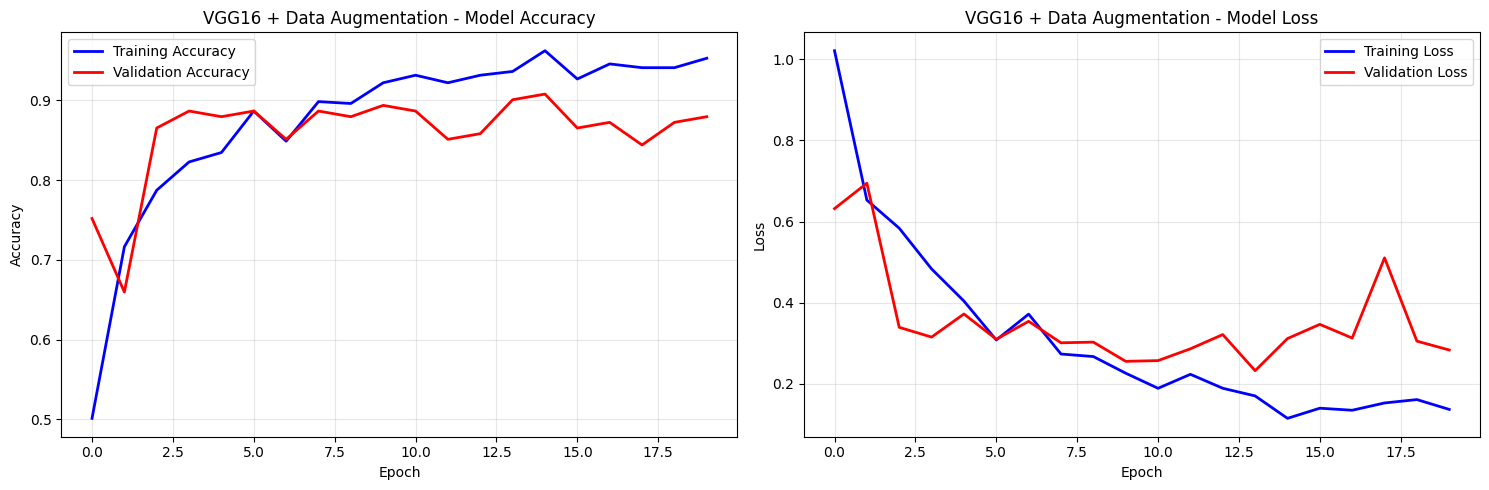


📊 VGG16 + Data Augmentation RESULTS:
Final Training Accuracy: 0.9527
Final Validation Accuracy: 0.8794
Best Validation Accuracy: 0.9078

EVALUATING VGG16 + AUGMENTATION ON TEST SET
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 390ms/step - accuracy: 0.8998 - loss: 0.3042

🎯 TEST RESULTS:
Test Accuracy: 0.8732
Test Loss: 0.3483
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 461ms/step


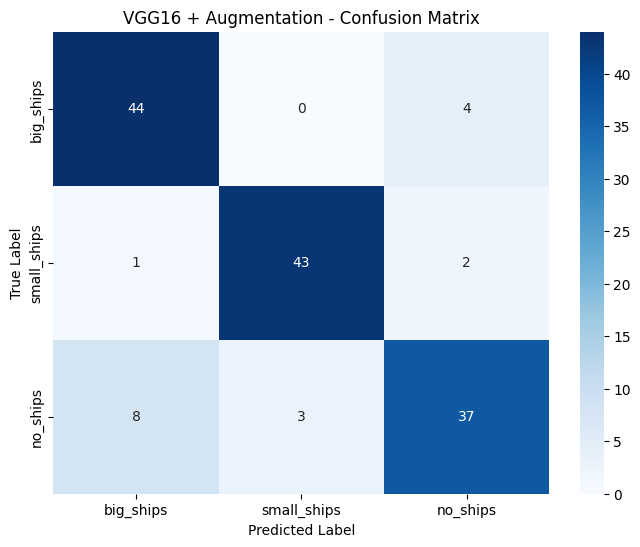


VGG16 + Augmentation Classification Report:
              precision    recall  f1-score   support

   big_ships       0.83      0.92      0.87        48
 small_ships       0.93      0.93      0.93        46
    no_ships       0.86      0.77      0.81        48

    accuracy                           0.87       142
   macro avg       0.88      0.87      0.87       142
weighted avg       0.87      0.87      0.87       142



In [ ]:
print("\n" + "="*60)
print("🔥 EXPERIMENT 1: VGG16 WITH DATA AUGMENTATION")
print("="*60)

# Train VGG16 with augmentation
vgg16_model_aug, vgg16_base_aug = create_vgg16_model()
history_vgg16_aug = train_model(vgg16_model_aug, train_gen_aug, val_gen_aug, "vgg16_augmented", epochs=20)
val_acc_vgg16_aug = plot_training_history(history_vgg16_aug, "VGG16 + Data Augmentation")
test_acc_vgg16_aug, _ = evaluate_model(vgg16_model_aug, test_gen_aug, "VGG16 + Augmentation", class_names)
part4_results['VGG16 + Aug'] = {'val_acc': val_acc_vgg16_aug, 'test_acc': test_acc_vgg16_aug}


🔥 EXPERIMENT 2: VGG19 WITH DATA AUGMENTATION

🏗️ VGG19 Transfer Learning Model
- Pre-trained on ImageNet (deeper than VGG16)
- Base model frozen
- Custom classifier: GAP → Dense(256) → Dense(3)
- Input size: 224×224
- Learning rate: 0.001

TRAINING VGG19_AUGMENTED
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.4846 - loss: 1.0713
Epoch 1: val_accuracy improved from -inf to 0.75177, saving model to best_vgg19_augmented.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 679ms/step - accuracy: 0.4870 - loss: 1.0667 - val_accuracy: 0.7518 - val_loss: 0.6019 - learning_rate: 0.0010
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.7440 - loss: 0.6544
Epoch 2: val_accuracy improved from 0.75177 to 0.76596, saving model to best_vgg19_augmented.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 626ms/step - accuracy: 0.7433 - loss: 0.6549 - val_accuracy: 0.7660 - val_loss: 0.5455 - learning_rate: 0.0010
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.7695 - loss: 0.5755
Epoch 3: val_accuracy improved from 0.76596 to 0.84397, saving model to best_vgg19_augmented.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 611ms/step - accuracy: 0.7692 - loss: 0.5757 - val_accuracy: 0.8440 - val_loss: 0.3666 - learning_rate: 0.0010
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.7887 - loss: 0.5233
Epoch 4: val_accuracy did not improve from 0.84397
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 576ms/step - accuracy: 0.7897 - loss: 0.5218 - val_accuracy: 0.8298 - val_loss: 0.3756 - learning_rate: 0.0010
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.7929 - loss: 0.4976
Epoch 5: val_accuracy improved from 0.84397 to 0.89362, saving model to best_vgg19_augmented.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 630ms/step - accuracy: 0.7933 - loss: 0.4969 - val_accuracy: 0.8936 - val_loss: 0.3814 - learning_rate: 0.0010
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.8208 - loss: 0.3962
Epoch 6: val_accuracy improved from 0.89362 to 0.90780, saving model to best_vgg19_augmented.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 620ms/step - accuracy: 0.8214 - loss: 0.3953 - val_accuracy: 0.9078 - val_loss: 0.2790 - learning_rate: 0.0010
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.8370 - loss: 0.4455
Epoch 7: val_accuracy did not improve from 0.90780
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 597ms/step - accuracy: 0.8377 - loss: 0.4436 - val_accuracy: 0.9078 - val_loss: 0.2587 - learning_rate: 0.0010
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.8651 - loss: 0.3493
Epoch 8: val_accuracy did not improve from 0.90780
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 668ms/step - accuracy: 0.8652 - loss: 0.3486 - val_accuracy: 0.8936 - val_loss: 0.2778 - learning_rate: 0.0010
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.8994 - loss: 0.2806
Epoch 9: val_accuracy did not improve from 0.90780
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 593ms/step - accuracy: 0.8988 - loss: 0.2814 - val_accuracy: 0.8652 - val_loss: 0.3194 - learning_rate: 0.0010
Epoch 10/20
27/27 ━━━

27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 586ms/step - accuracy: 0.9412 - loss: 0.1603 - val_accuracy: 0.9149 - val_loss: 0.2452 - learning_rate: 3.0000e-04
Epoch 16/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.9577 - loss: 0.1174
Epoch 16: val_accuracy did not improve from 0.91489
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 574ms/step - accuracy: 0.9576 - loss: 0.1176 - val_accuracy: 0.9149 - val_loss: 0.3034 - learning_rate: 3.0000e-04
Epoch 17/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.9653 - loss: 0.0992
Epoch 17: val_accuracy did not improve from 0.91489
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 594ms/step - accuracy: 0.9649 - loss: 0.0999 - val_accuracy: 0.9078 - val_loss: 0.2442 - learning_rate: 3.0000e-04
Epoch 18/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.9631 - loss: 0.1100
Epoch 18: val_accuracy did not improve from 0.91489
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 679ms/step - accuracy: 0.9631 - loss: 0.1101 - val_accuracy: 0.9078 - val_loss: 0.2803 - learning_rate: 3.0000e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 584ms/step - accuracy: 0.9619 - loss: 0.1416 - val_accuracy: 0.9220 - val_loss: 0.2745 - learning_rate: 3.0000e-04
Epoch 20/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.9666 - loss: 0.1098
Epoch 20: val_accuracy did not improve from 0.92199
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 595ms/step - accuracy: 0.9662 - loss: 0.1105 - val_accuracy: 0.9078 - val_loss: 0.2584 - learning_rate: 3.0000e-04


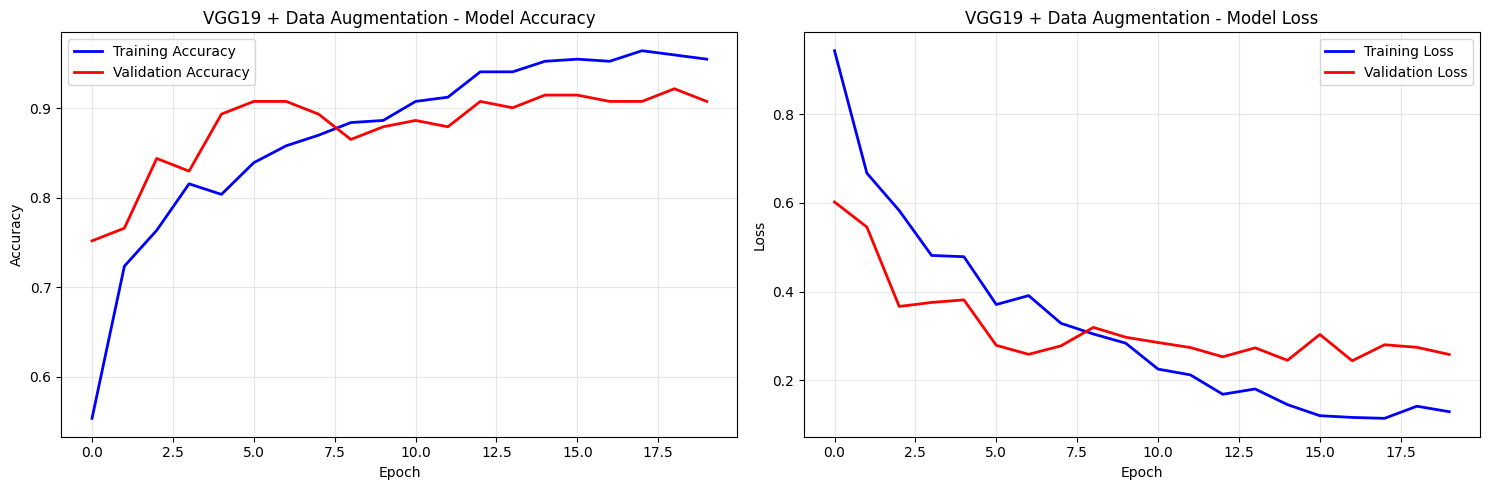


📊 VGG19 + Data Augmentation RESULTS:
Final Training Accuracy: 0.9551
Final Validation Accuracy: 0.9078
Best Validation Accuracy: 0.9220

EVALUATING VGG19 + AUGMENTATION ON TEST SET
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 400ms/step - accuracy: 0.8709 - loss: 0.2975

🎯 TEST RESULTS:
Test Accuracy: 0.8592
Test Loss: 0.3575
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 401ms/step


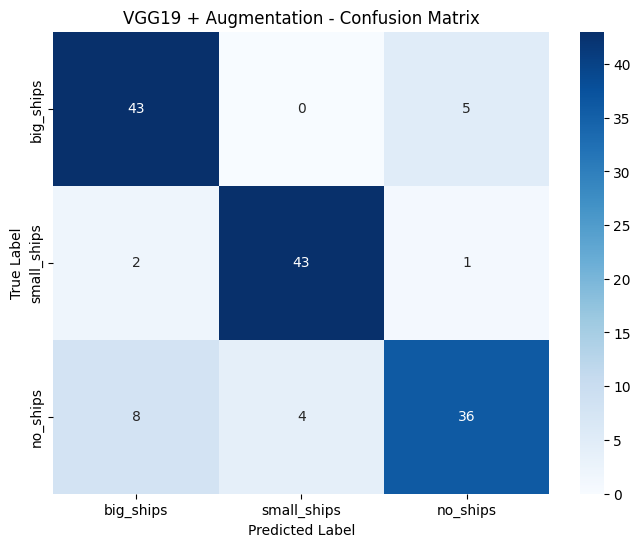


VGG19 + Augmentation Classification Report:
              precision    recall  f1-score   support

   big_ships       0.81      0.90      0.85        48
 small_ships       0.91      0.93      0.92        46
    no_ships       0.86      0.75      0.80        48

    accuracy                           0.86       142
   macro avg       0.86      0.86      0.86       142
weighted avg       0.86      0.86      0.86       142



In [ ]:
print("\n" + "="*60)
print("🔥 EXPERIMENT 2: VGG19 WITH DATA AUGMENTATION")
print("="*60)

# Train VGG19 with augmentation
vgg19_model_aug, vgg19_base_aug = create_vgg19_model()
history_vgg19_aug = train_model(vgg19_model_aug, train_gen_aug, val_gen_aug, "vgg19_augmented", epochs=20)
val_acc_vgg19_aug = plot_training_history(history_vgg19_aug, "VGG19 + Data Augmentation")
test_acc_vgg19_aug, _ = evaluate_model(vgg19_model_aug, test_gen_aug, "VGG19 + Augmentation", class_names)
part4_results['VGG19 + Aug'] = {'val_acc': val_acc_vgg19_aug, 'test_acc': test_acc_vgg19_aug}


🔥 EXPERIMENT 4: MobileNetV2 WITH DATA AUGMENTATION

🏗️ MobileNetV2 Transfer Learning Model
- Pre-trained on ImageNet (lightweight architecture)
- Base model frozen
- Custom classifier: GAP → Dense(128) → Dense(64) → Dense(3)
- Input size: 224×224
- Learning rate: 0.001

TRAINING MOBILENET_AUGMENTED
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.6178 - loss: 1.1494
Epoch 1: val_accuracy improved from -inf to 0.83688, saving model to best_mobilenet_augmented.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 888ms/step - accuracy: 0.6211 - loss: 1.1412 - val_accuracy: 0.8369 - val_loss: 0.4157 - learning_rate: 0.0010
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.8296 - loss: 0.4407
Epoch 2: val_accuracy improved from 0.83688 to 0.92199, saving model to best_mobilenet_augmented.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 595ms/step - accuracy: 0.8301 - loss: 0.4389 - val_accuracy: 0.9220 - val_loss: 0.2313 - learning_rate: 0.0010
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.9083 - loss: 0.2237
Epoch 3: val_accuracy improved from 0.92199 to 0.93617, saving model to best_mobilenet_augmented.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 611ms/step - accuracy: 0.9081 - loss: 0.2245 - val_accuracy: 0.9362 - val_loss: 0.3130 - learning_rate: 0.0010
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9005 - loss: 0.2243
Epoch 4: val_accuracy did not improve from 0.93617
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 579ms/step - accuracy: 0.9012 - loss: 0.2236 - val_accuracy: 0.9007 - val_loss: 0.3789 - learning_rate: 0.0010
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.9210 - loss: 0.1685
Epoch 5: val_accuracy improved from 0.93617 to 0.94326, saving model to best_mobilenet_augmented.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 587ms/step - accuracy: 0.9211 - loss: 0.1697 - val_accuracy: 0.9433 - val_loss: 0.2120 - learning_rate: 0.0010
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.9152 - loss: 0.2080
Epoch 6: val_accuracy improved from 0.94326 to 0.95745, saving model to best_mobilenet_augmented.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 604ms/step - accuracy: 0.9156 - loss: 0.2085 - val_accuracy: 0.9574 - val_loss: 0.1869 - learning_rate: 0.0010
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.9354 - loss: 0.1864
Epoch 7: val_accuracy did not improve from 0.95745
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 580ms/step - accuracy: 0.9355 - loss: 0.1866 - val_accuracy: 0.9220 - val_loss: 0.2857 - learning_rate: 0.0010
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.9268 - loss: 0.2004
Epoch 8: val_accuracy did not improve from 0.95745
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 583ms/step - accuracy: 0.9270 - loss: 0.2004 - val_accuracy: 0.9078 - val_loss: 0.3588 - learning_rate: 0.0010
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.9629 - loss: 0.1285
Epoch 9: val_accuracy did not improve from 0.95745
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 577ms/step - accuracy: 0.9626 - loss: 0.1299 - val_accuracy: 0.9504 - val_loss: 0.2639 - learning_rate: 0.0010
Epoch 10/20
27/27 ━━━

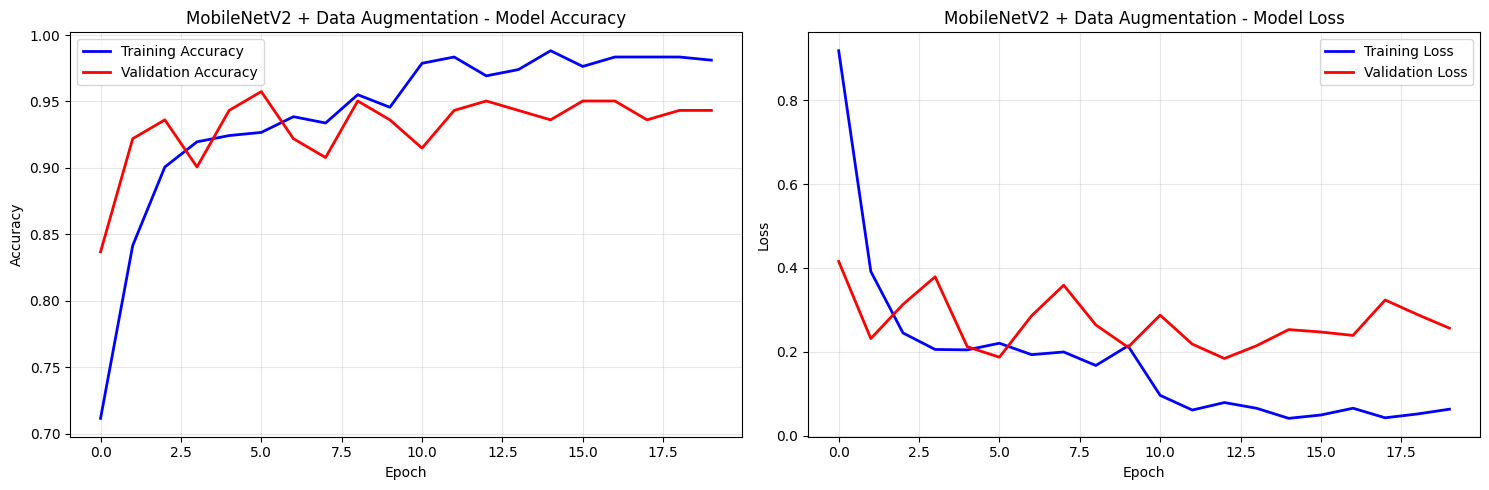


📊 MobileNetV2 + Data Augmentation RESULTS:
Final Training Accuracy: 0.9811
Final Validation Accuracy: 0.9433
Best Validation Accuracy: 0.9574

EVALUATING MOBILENETV2 + AUGMENTATION ON TEST SET
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 528ms/step - accuracy: 0.9444 - loss: 0.4301

🎯 TEST RESULTS:
Test Accuracy: 0.9577
Test Loss: 0.2659
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 662ms/step


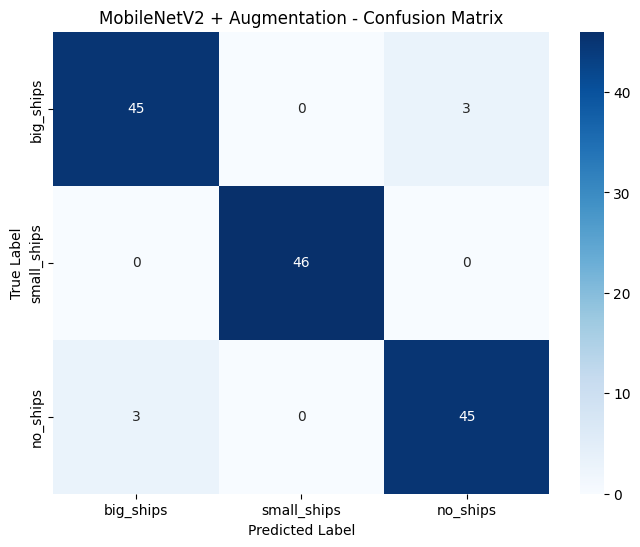


MobileNetV2 + Augmentation Classification Report:
              precision    recall  f1-score   support

   big_ships       0.94      0.94      0.94        48
 small_ships       1.00      1.00      1.00        46
    no_ships       0.94      0.94      0.94        48

    accuracy                           0.96       142
   macro avg       0.96      0.96      0.96       142
weighted avg       0.96      0.96      0.96       142



In [ ]:
print("\n" + "="*60)
print("🔥 EXPERIMENT 4: MobileNetV2 WITH DATA AUGMENTATION")
print("="*60)

# Train MobileNetV2 with augmentation
mobilenet_model_aug, mobilenet_base_aug = create_mobilenet_model()
history_mobilenet_aug = train_model(mobilenet_model_aug, train_gen_aug, val_gen_aug, "mobilenet_augmented", epochs=20)
val_acc_mobilenet_aug = plot_training_history(history_mobilenet_aug, "MobileNetV2 + Data Augmentation")
test_acc_mobilenet_aug, _ = evaluate_model(mobilenet_model_aug, test_gen_aug, "MobileNetV2 + Augmentation", class_names)
part4_results['MobileNetV2 + Aug'] = {'val_acc': val_acc_mobilenet_aug, 'test_acc': test_acc_mobilenet_aug}


📊 PART 4 RESULTS: IMPACT OF DATA AUGMENTATION ON TRANSFER LEARNING


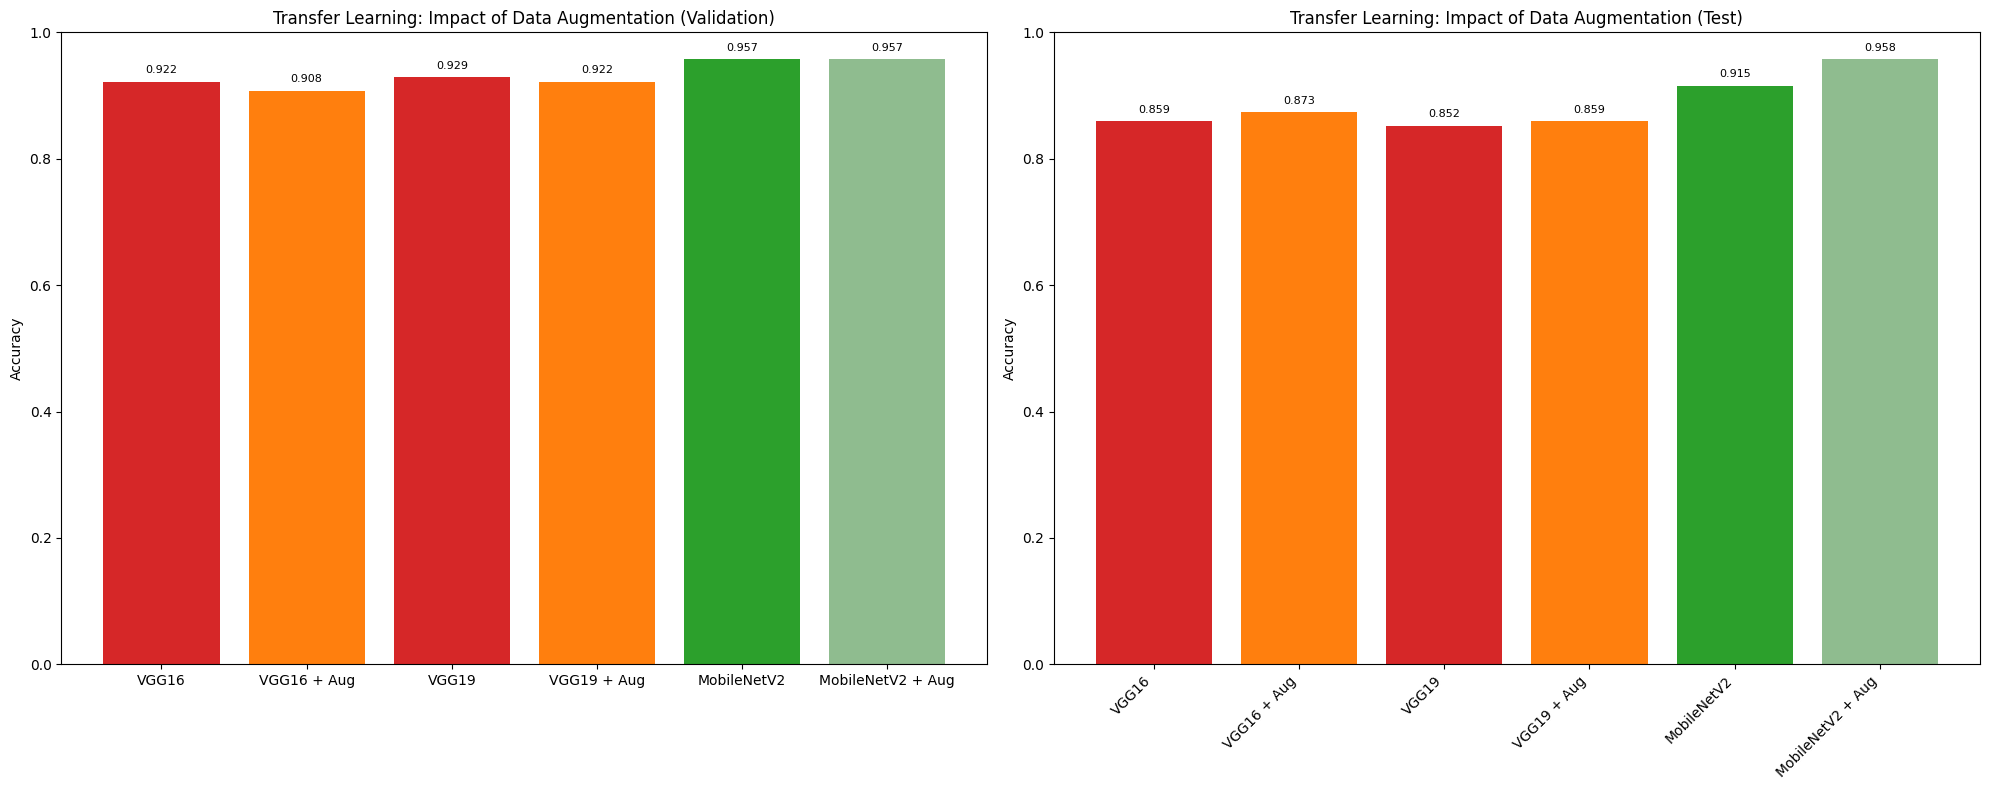


🎯 PART 4 TRANSFER LEARNING AUGMENTATION ANALYSIS:
------------------------------------------------------------
VGG16:
  Original → Val: 0.9220, Test: 0.8592
  With Aug → Val: 0.9078 (-0.0142), Test: 0.8732 (+0.0141)

VGG19:
  Original → Val: 0.9291, Test: 0.8521
  With Aug → Val: 0.9220 (-0.0071), Test: 0.8592 (+0.0070)

MobileNetV2:
  Original → Val: 0.9574, Test: 0.9155
  With Aug → Val: 0.9574 (+0.0000), Test: 0.9577 (+0.0423)


✅ Part 4 Complete! All transfer learning models tested with data augmentation


In [ ]:
# Compare transfer learning with and without augmentation
print("\n" + "="*60)
print("📊 PART 4 RESULTS: IMPACT OF DATA AUGMENTATION ON TRANSFER LEARNING")
print("="*60)

# Create comprehensive comparison
transfer_models = ['VGG16', 'VGG16 + Aug', 'VGG19', 'VGG19 + Aug',
                  'MobileNetV2', 'MobileNetV2 + Aug']


transfer_val_accs = [
    part2_results['VGG16']['val_acc'], val_acc_vgg16_aug,
    part2_results['VGG19']['val_acc'], val_acc_vgg19_aug,
    part2_results['MobileNetV2']['val_acc'], val_acc_mobilenet_aug
]

transfer_test_accs = [
    part2_results['VGG16']['test_acc'], test_acc_vgg16_aug,
    part2_results['VGG19']['test_acc'], test_acc_vgg19_aug,
    part2_results['MobileNetV2']['test_acc'], test_acc_mobilenet_aug
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Validation accuracy comparison
colors = ['#d62728', '#ff7f0e', '#d62728', '#ff7f0e', '#2ca02c', '#8FBC8F',
          '#9467bd', '#DDA0DD', '#8c564b', '#D2B48C']
bars1 = ax1.bar(transfer_models, transfer_val_accs, color=colors)
ax1.set_title('Transfer Learning: Impact of Data Augmentation (Validation)')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
for bar, acc in zip(bars1, transfer_val_accs):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontsize=8)

# Test accuracy comparison
bars2 = ax2.bar(transfer_models, transfer_test_accs, color=colors)
ax2.set_title('Transfer Learning: Impact of Data Augmentation (Test)')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)
for bar, acc in zip(bars2, transfer_test_accs):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontsize=8)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"\n🎯 PART 4 TRANSFER LEARNING AUGMENTATION ANALYSIS:")
print("-" * 60)

# Individual model comparisons
models_to_compare = ['VGG16', 'VGG19','MobileNetV2']
for model in models_to_compare:
    original_val = part2_results[model]['val_acc']
    original_test = part2_results[model]['test_acc']

    # Get augmented results
    if model == 'VGG16':
        aug_val, aug_test = val_acc_vgg16_aug, test_acc_vgg16_aug
    elif model == 'VGG19':
        aug_val, aug_test = val_acc_vgg19_aug, test_acc_vgg19_aug
    else:
        aug_val, aug_test = val_acc_mobilenet_aug, test_acc_mobilenet_aug

    val_improvement = aug_val - original_val
    test_improvement = aug_test - original_test

    print(f"{model}:")
    print(f"  Original → Val: {original_val:.4f}, Test: {original_test:.4f}")
    print(f"  With Aug → Val: {aug_val:.4f} ({val_improvement:+.4f}), Test: {aug_test:.4f} ({test_improvement:+.4f})")
    print()

print(f"\n✅ Part 4 Complete! All transfer learning models tested with data augmentation")

# 🏆 FINAL COMPREHENSIVE COMPARISON

In [ ]:
print("\n" + "="*80)
print("🏆 FINAL COMPREHENSIVE COMPARISON - ALL EXPERIMENTS")
print("="*80)

# Combine all results
all_results = {}

# Part 1: Custom CNNs (no augmentation)
for model_name, results in part1_results.items():
    all_results[model_name] = results['test_acc']

# Part 2: Transfer Learning (no augmentation)
for model_name, results in part2_results.items():
    all_results[model_name] = results['test_acc']

# Part 3: Best custom CNN with augmentation
all_results[f"{best_custom_model} + Augmentation"] = test_acc_aug

# Part 4: Transfer learning with augmentation
all_results['VGG16 + Augmentation'] = test_acc_vgg16_aug
all_results['VGG19 + Augmentation'] = test_acc_vgg19_aug
all_results['EfficientNetB0 + Augmentation'] = test_acc_efficientnet_aug
all_results['MobileNetV2 + Augmentation'] = test_acc_mobilenet_aug
all_results['ResNet50 + Augmentation'] = test_acc_resnet50_aug

# Sort results by test accuracy
sorted_results = sorted(all_results.items(), key=lambda x: x[1], reverse=True)

print("\n📊 COMPLETE PERFORMANCE RANKING (by Test Accuracy):")
print("=" * 60)
for i, (model_name, accuracy) in enumerate(sorted_results, 1):
    print(f"{i:2d}. {model_name:<40} {accuracy:.4f}")

# Create final comprehensive visualization
plt.figure(figsize=(18, 10))

# Separate models by category for color coding
all_models = [item[0] for item in sorted_results]
all_accuracies = [item[1] for item in sorted_results]

# Color coding based on categories
colors = []
for model_name in all_models:
    if 'CNN Architecture' in model_name:
        if 'Augmentation' in model_name:
            colors.append('#2ca02c')  # Green for custom + aug
        else:
            colors.append('#1f77b4')  # Blue for custom
    else:
        if 'Augmentation' in model_name:
            colors.append('#ff7f0e')  # Orange for transfer + aug
        else:
            colors.append('#d62728')  # Red for transfer

bars = plt.bar(range(len(all_models)), all_accuracies, color=colors)
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.title('Complete Model Performance Comparison\n(Blue: Custom CNNs, Green: Custom+Aug, Red: Transfer Learning, Orange: Transfer+Aug)')
plt.xticks(range(len(all_models)), all_models, rotation=45, ha='right')
plt.ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, all_accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Category analysis
print("\n📈 ANALYSIS BY EXPERIMENT TYPE:")
print("=" * 50)

# Custom CNNs
custom_accs = [acc for name, acc in all_results.items() if 'CNN Architecture' in name and 'Augmentation' not in name]
custom_aug_acc = test_acc_aug

# Transfer Learning
transfer_accs = [acc for name, acc in all_results.items() if any(x in name for x in ['VGG16', 'VGG19', 'EfficientNetB0', 'MobileNetV2', 'ResNet50']) and 'Augmentation' not in name]
transfer_aug_accs = [test_acc_vgg16_aug, test_acc_vgg19_aug, test_acc_efficientnet_aug, test_acc_mobilenet_aug, test_acc_resnet50_aug]

print(f"1. Custom CNNs (4 variations)    → Average: {np.mean(custom_accs):.4f}, Best: {max(custom_accs):.4f}")
print(f"2. Transfer Learning (5 models)  → Average: {np.mean(transfer_accs):.4f}, Best: {max(transfer_accs):.4f}")
print(f"3. Best Custom + Augmentation    → {custom_aug_acc:.4f}")
print(f"4. Transfer Learning + Aug       → Average: {np.mean(transfer_aug_accs):.4f}, Best: {max(transfer_aug_accs):.4f}")

print(f"\n🥇 OVERALL BEST MODEL: {sorted_results[0][0]}")
print(f"   Test Accuracy: {sorted_results[0][1]:.4f}")

print(f"\n🎯 KEY FINDINGS:")
print("-" * 30)
if max(transfer_accs) > max(custom_accs):
    print("✅ Transfer learning outperformed custom CNNs")
else:
    print("✅ Custom CNNs competitive with transfer learning")

if custom_aug_acc > max(custom_accs):
    print("✅ Data augmentation improved best custom CNN")
else:
    print("⚠️ Data augmentation had mixed effects on custom CNN")

if max(transfer_aug_accs) > max(transfer_accs):
    print("✅ Data augmentation improved transfer learning")
else:
    print("⚠️ Data augmentation had mixed effects on transfer learning")

print(f"\n🎉 PROJECT COMPLETED SUCCESSFULLY!")
print("=" * 60)
print("✅ Part 1: Custom CNN architectures (4 variations) explored and compared")
print("✅ Part 2: Transfer learning models (VGG16, ResNet50) trained and evaluated")
print("✅ Part 3: Data augmentation applied to best custom CNN")
print("✅ Part 4: Data augmentation applied to transfer learning models")
print("✅ Comprehensive evaluation and comparison completed")
print("\n🚢 All requirements fulfilled for vessel classification project!")
print("📊 Ready for submission with complete analysis and insights!")


🏆 FINAL COMPREHENSIVE COMPARISON - ALL EXPERIMENTS


NameError: name 'test_acc_efficientnet_aug' is not defined